In [99]:
import flwr as fl
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import argparse
import os
import sys
import time
import copy
import random
import argparse
import warnings
from collections import OrderedDict
import timeit
import flwr as fl
from flwr_datasets import FederatedDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision.transforms import Compose, Normalize, ToTensor
from tqdm import tqdm
from torch import Tensor
from torchvision import datasets
from torch import optim
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from sklearn.model_selection import StratifiedShuffleSplit
from typing import Callable, List, Optional, Tuple, Dict
from flwr.common import Scalar, Metrics

In [154]:
def load_mnist():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_set = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    test_set = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    
    X_train = train_set.data.numpy()
    y_train = train_set.targets.numpy()
    X_test = test_set.data.numpy()
    y_test = test_set.targets.numpy()
    
   
    # add extra dimension for channels
    X_train = X_train.reshape(-1, 1, 28, 28)
    X_test = X_test.reshape(-1, 1, 28, 28)
    return X_train, y_train, X_test, y_test

def stratified_partition(X, y, n_clients=5, test_size=0.2):
    sss = StratifiedShuffleSplit(n_splits=n_clients, test_size=test_size, random_state=0)
    client_data = []
    for train_idx, test_idx in sss.split(X, y):
        X_client, y_client = X[train_idx], y[train_idx]
        X_val, y_val = X[test_idx], y[test_idx]
        client_data.append((X_client, y_client, X_val, y_val))
    return client_data

def partition_data(n_clients=5):
    X_train, y_train, X_test, y_test = load_mnist()
    client_data = stratified_partition(X_train, y_train, n_clients=n_clients, test_size=0.2)
    server_holdout = (X_test, y_test)
    return client_data, server_holdout

def get_dataloaders(n_clients=5):
    client_data, server_holdout = partition_data(n_clients=n_clients)
    train_loaders = []
    val_loaders = []
    test_loader = []
    for cd in client_data:
        train_loaders.append(DataLoader(TensorDataset(Tensor(cd[0]), torch.LongTensor(cd[1])), batch_size=32, shuffle=True))
        val_loaders.append(DataLoader(TensorDataset(Tensor(cd[2]), torch.LongTensor(cd[3])), batch_size=32, shuffle=False))
    test_loader = DataLoader(TensorDataset(Tensor(server_holdout[0]), torch.LongTensor(server_holdout[1])), batch_size=32, shuffle=False)
    return train_loaders, val_loaders, test_loader

In [156]:
class MNISTNet(nn.Module):
    """Simple CNN adapted from Pytorch's 'Basic MNIST Example'."""

    def __init__(self) -> None:
        super(MNISTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(7*7*64, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x: Tensor) -> Tensor:
        """Compute forward pass.

        Parameters
        ----------
        x: Tensor
            Mini-batch of shape (N,28,28) containing images from MNIST dataset.


        Returns
        -------
        output: Tensor
            The unnormalized output being from a specific class given the input.
        """
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = x.view(-1, 7*7*64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [157]:
def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [158]:
import timeit
from copy import deepcopy
from torchvision.models import resnet18
from flwr.common import (
    Code,
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    GetParametersIns,
    GetParametersRes,
    Status,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
def get_weights(model: torch.nn.ModuleList) -> fl.common.NDArrays:
    """Get model weights as a list of NumPy ndarrays."""
    return [val.cpu().numpy() for _, val in model.state_dict().items()]


def set_weights(model: torch.nn.ModuleList, weights: fl.common.NDArrays) -> None:
    """Set model weights from a list of NumPy ndarrays."""
    state_dict = OrderedDict(
        {
            k: torch.tensor(np.atleast_1d(v))
            for k, v in zip(model.state_dict().keys(), weights)
        }
    )
    model.load_state_dict(state_dict, strict=True)


class MNISTClient(fl.client.Client):
    """Flower client implementing ImageNet image classification using PyTorch."""

    def __init__(
        self,
        cid: str,
        trainloader: torch.utils.data.DataLoader,
        testloader: torch.utils.data.DataLoader,
        nb_clients: int,
        
    ) -> None:
        self.cid = cid
        self.model = MNISTNet().to(DEVICE)
        self.trainloader = trainloader
        self.testloader = testloader
        self.nb_clients = nb_clients

        

    def get_parameters(self, config): #-> fl.common.ParametersRes:
        print(f"Client {self.cid}: get_parameters")
        weights: fl.common.NDArrays = get_weights(self.model)
        parameters = fl.common.ndarrays_to_parameters(weights)
        status = Status(code=Code.OK, message="Success")
        return GetParametersRes(
            status=status,
            parameters=parameters,
        )

    def fit(self, ins: fl.common.FitIns): #-> fl.common.FitRes:
        # Set the seed so we are sure to generate the same global batches
        # indices across all clients
        np.random.seed(123)

        print(f"Client {self.cid}: fit")

        weights: fl.common.NDArrays = fl.common.parameters_to_ndarrays(ins.parameters)
        config = ins.config
        fit_begin = timeit.default_timer()

        # Set model parameters
        set_weights(self.model, weights)
        train(self.model, self.trainloader, epochs=1)
        
        # Return the refined weights and the number of examples used for training
        weights_prime: fl.common.NDArrays = get_weights(self.model)
        params_prime = fl.common.ndarrays_to_parameters(weights_prime)     
        status = Status(code=Code.OK, message="Success")
        return FitRes(
            status=status,
            parameters=params_prime,
            num_examples=len(self.trainloader),
            metrics={},
        )

    def evaluate(self, ins: fl.common.EvaluateIns) -> fl.common.EvaluateRes:
        # Set the set so we are sure to generate the same batches
        # across all clients.
        np.random.seed(123)

        print(f"Client {self.cid}: evaluate")

        # config = ins.config
        # batch_size = int(config["batch_size"])

        weights = fl.common.parameters_to_ndarrays(ins.parameters)

        # Use provided weights to update the local model
        set_weights(self.model, weights)
        loss, accuracy = test(self.model, self.testloader)
        status = Status(code=Code.OK, message="Success")
        # Return the number of evaluation examples and the evaluation result (loss)
        #print("im")
        return fl.common.EvaluateRes(
            status=status,
            loss=float(loss),
            num_examples=len(self.testloader),
            metrics = {"accuracy": float(accuracy),"loss": float(loss)},
        )

In [159]:
num_clients = 5
trainloaders, valloaders, testloader = get_dataloaders(n_clients=num_clients)
total_rounds = 20
alpha = 0.75
model = MNISTNet().to(DEVICE)
model_parameters = get_weights(model)
model_parameters = fl.common.ndarrays_to_parameters(model_parameters)

# # Create client
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

def get_on_fit_config_fn(total_rounds, alpha):
    def fit_config(server_round: int):
        config = {
            "alpha": alpha,
            "total_rounds":total_rounds,
            "server_round": server_round,
        }
        return config
    return fit_config

def numpyclient_fn(cid) -> MNISTClient:
    trainloader = trainloaders[int(cid)]
    testloader = valloaders[int(cid)]
    return MNISTClient(cid, trainloader, testloader, 1)

def get_evaluate_fn(model):
    def evaluate(server_round: int, parameters: fl.common.NDArrays, config: Dict[str, Scalar]) -> Optional[Metrics]:
        global testloader
        set_weights(model, parameters)
        loss, accuracy = test(model, testloader)
        return loss, {"global_accuracy": accuracy}
    return evaluate
# start Flower simulation for a federated learning process

client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

hist = fl.simulation.start_simulation(
    client_fn=numpyclient_fn,
    num_clients=num_clients,
    config=fl.server.ServerConfig(num_rounds=total_rounds),
    client_resources=client_resources,
    strategy=fl.server.strategy.FedAvg(
        evaluate_metrics_aggregation_fn=weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(total_rounds, alpha),
        evaluate_fn=get_evaluate_fn(model),
        initial_parameters=model_parameters,
        ),
    
)

INFO flwr 2023-12-12 22:03:14,243 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-12-12 22:03:26,448	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-12-12 22:03:30,755 | app.py:213 | Flower VCE: Ray initialized with resources: {'object_store_memory': 5749871001.0, 'memory': 11499742004.0, 'node:127.0.0.1': 1.0, 'node:__internal_head__': 1.0, 'CPU': 16.0, 'GPU': 1.0}
INFO flwr 2023-12-12 22:03:30,756 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
C:\Users\HamadAlHammadi\AppData\Local\Temp\ipykernel_31052\384470976.py:46: UserWarning: No `num_cpus` specified in `client_resources`. Using `num_cpus=1` for each client.
  hist = fl.simulation.start_simulation(
INFO flwr 2023-12-12 22:03:30,757 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_gpus': 1, 'num_cpus': 1}
INFO flwr 2023-12-12 22:03:30,771 | app.py:288 | Flower VCE: C

(DefaultActor pid=63288) Client 0: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.012019538320600986, accuracy 0.9302083333333333
(DefaultActor pid=63288) Client 3: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.01138934027403593, accuracy 0.9254583333333334
(DefaultActor pid=63288) Client 2: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.012083067558705807, accuracy 0.9256041666666667
(DefaultActor pid=63288) Client 4: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.010642509907484055, accuracy 0.9368125
(DefaultActor pid=63288) Client 1: fit


DEBUG flwr 2023-12-12 22:04:33,722 | server.py:236 | fit_round 1 received 5 results and 0 failures
WARNING flwr 2023-12-12 22:04:33,797 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


(DefaultActor pid=63288) Epoch 1: train loss 0.011943751014769077, accuracy 0.9265208333333333


INFO flwr 2023-12-12 22:04:34,295 | server.py:125 | fit progress: (1, 0.04493739082813263, {'global_accuracy': 0.7394}, 62.691489200049546)
DEBUG flwr 2023-12-12 22:04:34,296 | server.py:173 | evaluate_round 1: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 2: evaluate
(DefaultActor pid=63288) Client 0: evaluate
(DefaultActor pid=63288) Client 3: evaluate
(DefaultActor pid=63288) Client 4: evaluate
(DefaultActor pid=63288) Client 1: evaluate


DEBUG flwr 2023-12-12 22:04:51,446 | server.py:187 | evaluate_round 1 received 5 results and 0 failures
DEBUG flwr 2023-12-12 22:04:51,446 | server.py:222 | fit_round 2: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 1: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.003891581203788519, accuracy 0.9628333333333333
(DefaultActor pid=63288) Client 0: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.004068113397806883, accuracy 0.9610625
(DefaultActor pid=63288) Client 2: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.003943273331969976, accuracy 0.96325
(DefaultActor pid=63288) Client 3: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.004029184114187956, accuracy 0.9631041666666667
(DefaultActor pid=63288) Client 4: fit


DEBUG flwr 2023-12-12 22:05:45,705 | server.py:236 | fit_round 2 received 5 results and 0 failures


(DefaultActor pid=63288) Epoch 1: train loss 0.003932253923267126, accuracy 0.9631458333333334


INFO flwr 2023-12-12 22:05:46,368 | server.py:125 | fit progress: (2, 0.002839426964521408, {'global_accuracy': 0.9809}, 134.76430540002184)
DEBUG flwr 2023-12-12 22:05:46,369 | server.py:173 | evaluate_round 2: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 0: evaluate
(DefaultActor pid=63288) Client 2: evaluate
(DefaultActor pid=63288) Client 3: evaluate
(DefaultActor pid=63288) Client 4: evaluate
(DefaultActor pid=63288) Client 1: evaluate


DEBUG flwr 2023-12-12 22:06:05,061 | server.py:187 | evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2023-12-12 22:06:05,063 | server.py:222 | fit_round 3: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 1: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.002967695239931345, accuracy 0.9732916666666667
(DefaultActor pid=63288) Client 3: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.00290994206443429, accuracy 0.9739791666666666
(DefaultActor pid=63288) Client 4: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.002929175039753318, accuracy 0.9745416666666666
(DefaultActor pid=63288) Client 0: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.00292631471529603, accuracy 0.9734166666666667
(DefaultActor pid=63288) Client 2: fit


DEBUG flwr 2023-12-12 22:06:55,160 | server.py:236 | fit_round 3 received 5 results and 0 failures


(DefaultActor pid=63288) Epoch 1: train loss 0.0029241745360195637, accuracy 0.973375


INFO flwr 2023-12-12 22:06:55,752 | server.py:125 | fit progress: (3, 0.002108395080361515, {'global_accuracy': 0.9836}, 204.14743990002898)
DEBUG flwr 2023-12-12 22:06:55,753 | server.py:173 | evaluate_round 3: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 0: evaluate
(DefaultActor pid=63288) Client 1: evaluate
(DefaultActor pid=63288) Client 3: evaluate
(DefaultActor pid=63288) Client 2: evaluate
(DefaultActor pid=63288) Client 4: evaluate


DEBUG flwr 2023-12-12 22:07:14,058 | server.py:187 | evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2023-12-12 22:07:14,059 | server.py:222 | fit_round 4: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 2: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0025016949512064457, accuracy 0.9785208333333333
(DefaultActor pid=63288) Client 3: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0023795776069164276, accuracy 0.9794375
(DefaultActor pid=63288) Client 4: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0025527398101985455, accuracy 0.9782083333333333
(DefaultActor pid=63288) Client 1: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.002406707499176264, accuracy 0.979375
(DefaultActor pid=63288) Client 0: fit


DEBUG flwr 2023-12-12 22:08:04,491 | server.py:236 | fit_round 4 received 5 results and 0 failures


(DefaultActor pid=63288) Epoch 1: train loss 0.002477244706824422, accuracy 0.979375


INFO flwr 2023-12-12 22:08:05,081 | server.py:125 | fit progress: (4, 0.0016372121576336213, {'global_accuracy': 0.985}, 273.4764849000494)
DEBUG flwr 2023-12-12 22:08:05,082 | server.py:173 | evaluate_round 4: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 2: evaluate
(DefaultActor pid=63288) Client 3: evaluate
(DefaultActor pid=63288) Client 4: evaluate
(DefaultActor pid=63288) Client 0: evaluate
(DefaultActor pid=63288) Client 1: evaluate


DEBUG flwr 2023-12-12 22:08:23,314 | server.py:187 | evaluate_round 4 received 5 results and 0 failures
DEBUG flwr 2023-12-12 22:08:23,315 | server.py:222 | fit_round 5: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 1: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0023326172959059477, accuracy 0.9811458333333334
(DefaultActor pid=63288) Client 0: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0022552029695361853, accuracy 0.9813333333333333
(DefaultActor pid=63288) Client 2: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0022230525501072407, accuracy 0.9826875
(DefaultActor pid=63288) Client 3: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0021416060626506805, accuracy 0.9815208333333333
(DefaultActor pid=63288) Client 4: fit


DEBUG flwr 2023-12-12 22:09:13,876 | server.py:236 | fit_round 5 received 5 results and 0 failures


(DefaultActor pid=63288) Epoch 1: train loss 0.0022086086682975292, accuracy 0.9817916666666666


INFO flwr 2023-12-12 22:09:14,463 | server.py:125 | fit progress: (5, 0.001716925434244331, {'global_accuracy': 0.9862}, 342.85988840000937)
DEBUG flwr 2023-12-12 22:09:14,464 | server.py:173 | evaluate_round 5: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 1: evaluate
(DefaultActor pid=63288) Client 2: evaluate
(DefaultActor pid=63288) Client 4: evaluate
(DefaultActor pid=63288) Client 3: evaluate
(DefaultActor pid=63288) Client 0: evaluate


DEBUG flwr 2023-12-12 22:09:32,011 | server.py:187 | evaluate_round 5 received 5 results and 0 failures
DEBUG flwr 2023-12-12 22:09:32,012 | server.py:222 | fit_round 6: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 3: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.002057819627225399, accuracy 0.9845625
(DefaultActor pid=63288) Client 2: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0020943169947713614, accuracy 0.9834166666666667
(DefaultActor pid=63288) Client 1: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0021864911541342735, accuracy 0.9825416666666666
(DefaultActor pid=63288) Client 0: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0020964141003787518, accuracy 0.983875
(DefaultActor pid=63288) Client 4: fit


DEBUG flwr 2023-12-12 22:10:27,995 | server.py:236 | fit_round 6 received 5 results and 0 failures


(DefaultActor pid=63288) Epoch 1: train loss 0.002014587167650461, accuracy 0.9839583333333334


INFO flwr 2023-12-12 22:10:28,563 | server.py:125 | fit progress: (6, 0.001612220420235826, {'global_accuracy': 0.9867}, 416.95960680005373)
DEBUG flwr 2023-12-12 22:10:28,564 | server.py:173 | evaluate_round 6: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 0: evaluate
(DefaultActor pid=63288) Client 2: evaluate
(DefaultActor pid=63288) Client 3: evaluate
(DefaultActor pid=63288) Client 1: evaluate
(DefaultActor pid=63288) Client 4: evaluate


DEBUG flwr 2023-12-12 22:10:46,754 | server.py:187 | evaluate_round 6 received 5 results and 0 failures
DEBUG flwr 2023-12-12 22:10:46,755 | server.py:222 | fit_round 7: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 0: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0021069368813186884, accuracy 0.9847916666666666
(DefaultActor pid=63288) Client 4: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0019655381329357624, accuracy 0.986375
(DefaultActor pid=63288) Client 3: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0020099631510674953, accuracy 0.985
(DefaultActor pid=63288) Client 2: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0021335508208721876, accuracy 0.9844375
(DefaultActor pid=63288) Client 1: fit


DEBUG flwr 2023-12-12 22:11:38,698 | server.py:236 | fit_round 7 received 5 results and 0 failures


(DefaultActor pid=63288) Epoch 1: train loss 0.0020540114492177963, accuracy 0.9852083333333334


INFO flwr 2023-12-12 22:11:39,292 | server.py:125 | fit progress: (7, 0.0019113403011026093, {'global_accuracy': 0.9848}, 487.68880230002105)
DEBUG flwr 2023-12-12 22:11:39,294 | server.py:173 | evaluate_round 7: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 3: evaluate
(DefaultActor pid=63288) Client 0: evaluate
(DefaultActor pid=63288) Client 4: evaluate
(DefaultActor pid=63288) Client 2: evaluate
(DefaultActor pid=63288) Client 1: evaluate


DEBUG flwr 2023-12-12 22:11:57,837 | server.py:187 | evaluate_round 7 received 5 results and 0 failures
DEBUG flwr 2023-12-12 22:11:57,838 | server.py:222 | fit_round 8: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 0: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.002060017781332135, accuracy 0.9871666666666666
(DefaultActor pid=63288) Client 1: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0019538458436727524, accuracy 0.9863333333333333
(DefaultActor pid=63288) Client 4: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0020352096762508154, accuracy 0.9851666666666666
(DefaultActor pid=63288) Client 2: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.00196687038987875, accuracy 0.9864375
(DefaultActor pid=63288) Client 3: fit


DEBUG flwr 2023-12-12 22:12:50,551 | server.py:236 | fit_round 8 received 5 results and 0 failures


(DefaultActor pid=63288) Epoch 1: train loss 0.0021007880568504333, accuracy 0.9856666666666667


INFO flwr 2023-12-12 22:12:51,122 | server.py:125 | fit progress: (8, 0.0018960283478911151, {'global_accuracy': 0.9843}, 559.5172777000116)
DEBUG flwr 2023-12-12 22:12:51,123 | server.py:173 | evaluate_round 8: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 4: evaluate
(DefaultActor pid=63288) Client 1: evaluate
(DefaultActor pid=63288) Client 2: evaluate
(DefaultActor pid=63288) Client 0: evaluate
(DefaultActor pid=63288) Client 3: evaluate


DEBUG flwr 2023-12-12 22:13:12,390 | server.py:187 | evaluate_round 8 received 5 results and 0 failures
DEBUG flwr 2023-12-12 22:13:12,391 | server.py:222 | fit_round 9: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 3: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0019866195507347584, accuracy 0.986125
(DefaultActor pid=63288) Client 2: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0020754679571837187, accuracy 0.9864583333333333
(DefaultActor pid=63288) Client 1: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.002041658153757453, accuracy 0.9876875
(DefaultActor pid=63288) Client 0: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0019197635119780898, accuracy 0.9879583333333334
(DefaultActor pid=63288) Client 4: fit


DEBUG flwr 2023-12-12 22:14:03,556 | server.py:236 | fit_round 9 received 5 results and 0 failures


(DefaultActor pid=63288) Epoch 1: train loss 0.0021936153061687946, accuracy 0.9866041666666666


INFO flwr 2023-12-12 22:14:04,146 | server.py:125 | fit progress: (9, 0.0017948427019146037, {'global_accuracy': 0.9858}, 632.5413876000093)
DEBUG flwr 2023-12-12 22:14:04,146 | server.py:173 | evaluate_round 9: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 1: evaluate
(DefaultActor pid=63288) Client 3: evaluate
(DefaultActor pid=63288) Client 0: evaluate
(DefaultActor pid=63288) Client 2: evaluate
(DefaultActor pid=63288) Client 4: evaluate


DEBUG flwr 2023-12-12 22:14:21,876 | server.py:187 | evaluate_round 9 received 5 results and 0 failures
DEBUG flwr 2023-12-12 22:14:21,877 | server.py:222 | fit_round 10: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 2: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.002142533892765641, accuracy 0.9868958333333333
(DefaultActor pid=63288) Client 0: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0017778190085664392, accuracy 0.9885416666666667
(DefaultActor pid=63288) Client 3: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0021221910137683153, accuracy 0.9880416666666667
(DefaultActor pid=63288) Client 4: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.002173475455492735, accuracy 0.9877916666666666
(DefaultActor pid=63288) Client 1: fit


DEBUG flwr 2023-12-12 22:15:12,165 | server.py:236 | fit_round 10 received 5 results and 0 failures


(DefaultActor pid=63288) Epoch 1: train loss 0.0020630238577723503, accuracy 0.9871458333333333


INFO flwr 2023-12-12 22:15:12,754 | server.py:125 | fit progress: (10, 0.001987009185283387, {'global_accuracy': 0.9839}, 701.1500093000359)
DEBUG flwr 2023-12-12 22:15:12,755 | server.py:173 | evaluate_round 10: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 4: evaluate
(DefaultActor pid=63288) Client 1: evaluate
(DefaultActor pid=63288) Client 2: evaluate
(DefaultActor pid=63288) Client 3: evaluate
(DefaultActor pid=63288) Client 0: evaluate


DEBUG flwr 2023-12-12 22:15:30,124 | server.py:187 | evaluate_round 10 received 5 results and 0 failures
DEBUG flwr 2023-12-12 22:15:30,125 | server.py:222 | fit_round 11: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 1: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0019355134572833776, accuracy 0.98925
(DefaultActor pid=63288) Client 2: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0019496941240504384, accuracy 0.9888333333333333
(DefaultActor pid=63288) Client 3: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.002282076748088002, accuracy 0.9876875
(DefaultActor pid=63288) Client 4: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.001890407525934279, accuracy 0.9895833333333334
(DefaultActor pid=63288) Client 0: fit


DEBUG flwr 2023-12-12 22:16:21,142 | server.py:236 | fit_round 11 received 5 results and 0 failures


(DefaultActor pid=63288) Epoch 1: train loss 0.002069421112537384, accuracy 0.988875


INFO flwr 2023-12-12 22:16:21,735 | server.py:125 | fit progress: (11, 0.0018620494764836622, {'global_accuracy': 0.9852}, 770.1310351000284)
DEBUG flwr 2023-12-12 22:16:21,735 | server.py:173 | evaluate_round 11: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 3: evaluate
(DefaultActor pid=63288) Client 0: evaluate
(DefaultActor pid=63288) Client 1: evaluate
(DefaultActor pid=63288) Client 4: evaluate
(DefaultActor pid=63288) Client 2: evaluate


DEBUG flwr 2023-12-12 22:16:40,184 | server.py:187 | evaluate_round 11 received 5 results and 0 failures
DEBUG flwr 2023-12-12 22:16:40,184 | server.py:222 | fit_round 12: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 0: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0020934417843818665, accuracy 0.9889166666666667
(DefaultActor pid=63288) Client 4: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0022968912962824106, accuracy 0.9890833333333333
(DefaultActor pid=63288) Client 2: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0018241071375086904, accuracy 0.9895625
(DefaultActor pid=63288) Client 3: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0025553263258188963, accuracy 0.9886041666666666
(DefaultActor pid=63288) Client 1: fit


DEBUG flwr 2023-12-12 22:17:31,097 | server.py:236 | fit_round 12 received 5 results and 0 failures


(DefaultActor pid=63288) Epoch 1: train loss 0.0021806061267852783, accuracy 0.9886041666666666


INFO flwr 2023-12-12 22:17:31,668 | server.py:125 | fit progress: (12, 0.001799054597707436, {'global_accuracy': 0.9858}, 840.0644159000367)
DEBUG flwr 2023-12-12 22:17:31,669 | server.py:173 | evaluate_round 12: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 2: evaluate
(DefaultActor pid=63288) Client 4: evaluate
(DefaultActor pid=63288) Client 3: evaluate
(DefaultActor pid=63288) Client 0: evaluate
(DefaultActor pid=63288) Client 1: evaluate


DEBUG flwr 2023-12-12 22:17:49,218 | server.py:187 | evaluate_round 12 received 5 results and 0 failures
DEBUG flwr 2023-12-12 22:17:49,219 | server.py:222 | fit_round 13: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 1: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0020013758912682533, accuracy 0.989375
(DefaultActor pid=63288) Client 4: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0017795749008655548, accuracy 0.9910208333333334
(DefaultActor pid=63288) Client 0: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0020113580394536257, accuracy 0.9899375
(DefaultActor pid=63288) Client 2: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0024721859954297543, accuracy 0.9896041666666666
(DefaultActor pid=63288) Client 3: fit


DEBUG flwr 2023-12-12 22:18:38,952 | server.py:236 | fit_round 13 received 5 results and 0 failures


(DefaultActor pid=63288) Epoch 1: train loss 0.0023728511296212673, accuracy 0.9878125


INFO flwr 2023-12-12 22:18:39,522 | server.py:125 | fit progress: (13, 0.0019487131989914814, {'global_accuracy': 0.9856}, 907.9171757000149)
DEBUG flwr 2023-12-12 22:18:39,522 | server.py:173 | evaluate_round 13: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 3: evaluate
(DefaultActor pid=63288) Client 1: evaluate
(DefaultActor pid=63288) Client 4: evaluate
(DefaultActor pid=63288) Client 0: evaluate
(DefaultActor pid=63288) Client 2: evaluate


DEBUG flwr 2023-12-12 22:18:58,051 | server.py:187 | evaluate_round 13 received 5 results and 0 failures
DEBUG flwr 2023-12-12 22:18:58,052 | server.py:222 | fit_round 14: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 2: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0021938704885542393, accuracy 0.99075
(DefaultActor pid=63288) Client 4: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.002044237218797207, accuracy 0.989875
(DefaultActor pid=63288) Client 0: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0024507753551006317, accuracy 0.9897083333333333
(DefaultActor pid=63288) Client 1: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.002259212313219905, accuracy 0.989875
(DefaultActor pid=63288) Client 3: fit


DEBUG flwr 2023-12-12 22:19:47,536 | server.py:236 | fit_round 14 received 5 results and 0 failures


(DefaultActor pid=63288) Epoch 1: train loss 0.002439755480736494, accuracy 0.99


INFO flwr 2023-12-12 22:19:48,101 | server.py:125 | fit progress: (14, 0.002135006957185067, {'global_accuracy': 0.9851}, 976.4964903000509)
DEBUG flwr 2023-12-12 22:19:48,101 | server.py:173 | evaluate_round 14: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 1: evaluate
(DefaultActor pid=63288) Client 0: evaluate
(DefaultActor pid=63288) Client 3: evaluate
(DefaultActor pid=63288) Client 4: evaluate
(DefaultActor pid=63288) Client 2: evaluate


DEBUG flwr 2023-12-12 22:20:08,192 | server.py:187 | evaluate_round 14 received 5 results and 0 failures
DEBUG flwr 2023-12-12 22:20:08,193 | server.py:222 | fit_round 15: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 2: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0022827007342129946, accuracy 0.9910208333333334
(DefaultActor pid=63288) Client 0: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0024220538325607777, accuracy 0.9902083333333334
(DefaultActor pid=63288) Client 1: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0021893184166401625, accuracy 0.9898333333333333
(DefaultActor pid=63288) Client 3: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.002425882965326309, accuracy 0.9896458333333333
(DefaultActor pid=63288) Client 4: fit


DEBUG flwr 2023-12-12 22:20:57,071 | server.py:236 | fit_round 15 received 5 results and 0 failures


(DefaultActor pid=63288) Epoch 1: train loss 0.002543774200603366, accuracy 0.9904375


INFO flwr 2023-12-12 22:20:57,710 | server.py:125 | fit progress: (15, 0.002299448330799894, {'global_accuracy': 0.9857}, 1046.1057227000128)
DEBUG flwr 2023-12-12 22:20:57,711 | server.py:173 | evaluate_round 15: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 4: evaluate
(DefaultActor pid=63288) Client 0: evaluate
(DefaultActor pid=63288) Client 3: evaluate
(DefaultActor pid=63288) Client 2: evaluate
(DefaultActor pid=63288) Client 1: evaluate


DEBUG flwr 2023-12-12 22:21:14,501 | server.py:187 | evaluate_round 15 received 5 results and 0 failures
DEBUG flwr 2023-12-12 22:21:14,502 | server.py:222 | fit_round 16: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 2: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0020249506924301386, accuracy 0.9914791666666667
(DefaultActor pid=63288) Client 1: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0026213054079562426, accuracy 0.9903958333333334
(DefaultActor pid=63288) Client 3: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0021494957618415356, accuracy 0.9909583333333334
(DefaultActor pid=63288) Client 4: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0023041474632918835, accuracy 0.9919375
(DefaultActor pid=63288) Client 0: fit


DEBUG flwr 2023-12-12 22:22:03,866 | server.py:236 | fit_round 16 received 5 results and 0 failures


(DefaultActor pid=63288) Epoch 1: train loss 0.0024146607611328363, accuracy 0.99025


INFO flwr 2023-12-12 22:22:04,448 | server.py:125 | fit progress: (16, 0.002393210282122982, {'global_accuracy': 0.9868}, 1112.8439376000315)
DEBUG flwr 2023-12-12 22:22:04,449 | server.py:173 | evaluate_round 16: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 1: evaluate
(DefaultActor pid=63288) Client 2: evaluate
(DefaultActor pid=63288) Client 3: evaluate
(DefaultActor pid=63288) Client 0: evaluate
(DefaultActor pid=63288) Client 4: evaluate


DEBUG flwr 2023-12-12 22:22:21,271 | server.py:187 | evaluate_round 16 received 5 results and 0 failures
DEBUG flwr 2023-12-12 22:22:21,272 | server.py:222 | fit_round 17: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 0: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.002463029231876135, accuracy 0.9924166666666666
(DefaultActor pid=63288) Client 3: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0021056749392300844, accuracy 0.9916875
(DefaultActor pid=63288) Client 4: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.002907059621065855, accuracy 0.9910625
(DefaultActor pid=63288) Client 2: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.00261308322660625, accuracy 0.9922083333333334
(DefaultActor pid=63288) Client 1: fit


DEBUG flwr 2023-12-12 22:23:11,108 | server.py:236 | fit_round 17 received 5 results and 0 failures


(DefaultActor pid=63288) Epoch 1: train loss 0.002232514787465334, accuracy 0.9924166666666666


INFO flwr 2023-12-12 22:23:11,685 | server.py:125 | fit progress: (17, 0.002937755694939642, {'global_accuracy': 0.9866}, 1180.081163600029)
DEBUG flwr 2023-12-12 22:23:11,686 | server.py:173 | evaluate_round 17: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 2: evaluate
(DefaultActor pid=63288) Client 1: evaluate
(DefaultActor pid=63288) Client 3: evaluate
(DefaultActor pid=63288) Client 4: evaluate
(DefaultActor pid=63288) Client 0: evaluate


DEBUG flwr 2023-12-12 22:23:30,365 | server.py:187 | evaluate_round 17 received 5 results and 0 failures
DEBUG flwr 2023-12-12 22:23:30,366 | server.py:222 | fit_round 18: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 4: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0025112919975072145, accuracy 0.9915
(DefaultActor pid=63288) Client 0: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.002443562960252166, accuracy 0.9924166666666666
(DefaultActor pid=63288) Client 1: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.002229228848591447, accuracy 0.9925625
(DefaultActor pid=63288) Client 2: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.003150152275338769, accuracy 0.9910833333333333
(DefaultActor pid=63288) Client 3: fit


DEBUG flwr 2023-12-12 22:24:20,643 | server.py:236 | fit_round 18 received 5 results and 0 failures


(DefaultActor pid=63288) Epoch 1: train loss 0.0023293928243219852, accuracy 0.9917916666666666


INFO flwr 2023-12-12 22:24:21,220 | server.py:125 | fit progress: (18, 0.0029191623881500563, {'global_accuracy': 0.9862}, 1249.6150722000166)
DEBUG flwr 2023-12-12 22:24:21,220 | server.py:173 | evaluate_round 18: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 3: evaluate
(DefaultActor pid=63288) Client 4: evaluate
(DefaultActor pid=63288) Client 2: evaluate
(DefaultActor pid=63288) Client 1: evaluate
(DefaultActor pid=63288) Client 0: evaluate


DEBUG flwr 2023-12-12 22:24:39,393 | server.py:187 | evaluate_round 18 received 5 results and 0 failures
DEBUG flwr 2023-12-12 22:24:39,394 | server.py:222 | fit_round 19: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 0: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0020242638420313597, accuracy 0.9928541666666667
(DefaultActor pid=63288) Client 4: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.002107982523739338, accuracy 0.992875
(DefaultActor pid=63288) Client 2: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0028888676315546036, accuracy 0.9927083333333333
(DefaultActor pid=63288) Client 1: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.00310243247076869, accuracy 0.9916666666666667
(DefaultActor pid=63288) Client 3: fit


DEBUG flwr 2023-12-12 22:25:31,241 | server.py:236 | fit_round 19 received 5 results and 0 failures


(DefaultActor pid=63288) Epoch 1: train loss 0.0025848287623375654, accuracy 0.9923125


INFO flwr 2023-12-12 22:25:31,854 | server.py:125 | fit progress: (19, 0.003401674455965005, {'global_accuracy': 0.9856}, 1320.2504506999976)
DEBUG flwr 2023-12-12 22:25:31,855 | server.py:173 | evaluate_round 19: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 2: evaluate
(DefaultActor pid=63288) Client 4: evaluate
(DefaultActor pid=63288) Client 3: evaluate
(DefaultActor pid=63288) Client 0: evaluate
(DefaultActor pid=63288) Client 1: evaluate


DEBUG flwr 2023-12-12 22:25:50,072 | server.py:187 | evaluate_round 19 received 5 results and 0 failures
DEBUG flwr 2023-12-12 22:25:50,073 | server.py:222 | fit_round 20: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 3: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.002398807555437088, accuracy 0.9924375
(DefaultActor pid=63288) Client 0: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.0023176041431725025, accuracy 0.9935625
(DefaultActor pid=63288) Client 2: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.002705680439248681, accuracy 0.9924166666666666
(DefaultActor pid=63288) Client 4: fit
(DefaultActor pid=63288) Epoch 1: train loss 0.002783798612654209, accuracy 0.99325
(DefaultActor pid=63288) Client 1: fit


DEBUG flwr 2023-12-12 22:26:41,872 | server.py:236 | fit_round 20 received 5 results and 0 failures


(DefaultActor pid=63288) Epoch 1: train loss 0.0020593705121427774, accuracy 0.993875


INFO flwr 2023-12-12 22:26:42,514 | server.py:125 | fit progress: (20, 0.0036207671616817097, {'global_accuracy': 0.9863}, 1390.9091587000294)
DEBUG flwr 2023-12-12 22:26:42,514 | server.py:173 | evaluate_round 20: strategy sampled 5 clients (out of 5)


(DefaultActor pid=63288) Client 2: evaluate
(DefaultActor pid=63288) Client 4: evaluate
(DefaultActor pid=63288) Client 1: evaluate
(DefaultActor pid=63288) Client 0: evaluate
(DefaultActor pid=63288) Client 3: evaluate


DEBUG flwr 2023-12-12 22:27:00,108 | server.py:187 | evaluate_round 20 received 5 results and 0 failures
INFO flwr 2023-12-12 22:27:00,109 | server.py:153 | FL finished in 1408.5056773000397
INFO flwr 2023-12-12 22:27:00,113 | app.py:226 | app_fit: losses_distributed [(1, 0.044896644753217696), (2, 0.002770932712095479), (3, 0.001811996125181516), (4, 0.0011952823223507342), (5, 0.0010940806821008058), (6, 0.0009733197367114675), (7, 0.0011568834005476673), (8, 0.001137587755045388), (9, 0.0007697926061193964), (10, 0.0009703212530342474), (11, 0.0006373333718322101), (12, 0.0006189920151246648), (13, 0.0006193674597419885), (14, 0.000668001491732745), (15, 0.0005792112903080882), (16, 0.0004896563650705727), (17, 0.00038764177377342336), (18, 0.00038907620358649643), (19, 0.00037403881491067967), (20, 0.0002607614321392704)]
INFO flwr 2023-12-12 22:27:00,114 | app.py:227 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-12-12 22:27:00,114 | app.py:228 | app_fit: metrics_distributed

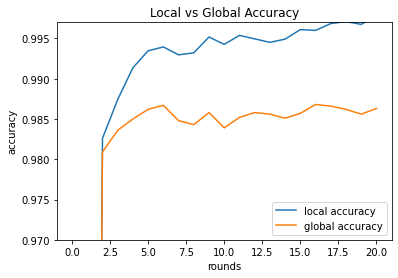

In [177]:
from matplotlib import pyplot as plt
dict1 = hist.metrics_distributed
dict2 = hist.metrics_centralized
plt.plot([i[0] for i in dict1['accuracy']], [i[1] for i in dict1['accuracy']], label='local accuracy')
plt.plot([i[0] for i in dict2['global_accuracy']], [i[1] for i in dict2['global_accuracy']], label='global accuracy')
plt.legend()
plt.xlabel('rounds')
plt.ylabel('accuracy')
plt.ylim(0.97, 0.997)
plt.title('Local vs Global Accuracy')
plt.show()


In [117]:
vars(hist)

{'losses_distributed': [(1, 0.048872522175312044),
  (2, 0.006404922062371458),
  (3, 0.0006447731634261019),
  (4, 0.0003516655256359787),
  (5, 0.0002796955520247458),
  (6, 0.0001607327592703539),
  (7, 0.0001436270376592407),
  (8, 3.899339501667708e-05),
  (9, 3.300315824449712e-05),
  (10, 1.7451970783067783e-05)],
 'losses_centralized': [(0, 0.3268317323752812),
  (1, 0.048784012011119295),
  (2, 0.006334159056576235),
  (3, 0.0005341819677476711),
  (4, 0.00025849312754395564),
  (5, 0.00020244152552227252),
  (6, 0.00010766530486010433),
  (7, 8.193370967139977e-05),
  (8, 1.847376079536802e-05),
  (9, 1.7413046183886045e-05),
  (10, 9.613601547271958e-06)],
 'metrics_distributed_fit': {},
 'metrics_distributed': {'accuracy': [(1, 0.7678428571428572),
   (2, 0.9598285714285715),
   (3, 0.9942857142857143),
   (4, 0.9965714285714286),
   (5, 0.9971428571428572),
   (6, 0.9984428571428571),
   (7, 0.9988714285714286),
   (8, 0.9996428571428572),
   (9, 0.9996999999999999),
   (1

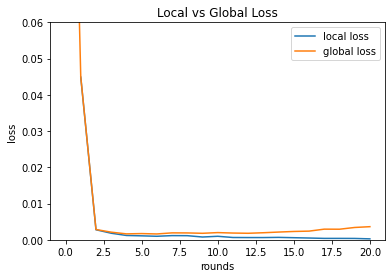

In [172]:
dict1 = hist.losses_distributed
dict2 = hist.losses_centralized
plt.plot([i[0] for i in dict1], [i[1] for i in dict1], label='local loss')
plt.plot([i[0] for i in dict2], [i[1] for i in dict2], label='global loss')
plt.legend()
plt.xlabel('rounds')
plt.ylabel('loss')
plt.ylim(0, 0.06)
plt.title('Local vs Global Loss')
plt.show()

In [173]:
import json
with open('hist_fedavg_mnist_20.json', 'w') as f:
    json.dump(vars(hist), f)

Now Lets Try Fedsoup

In [179]:
import timeit
from copy import deepcopy
from torchvision.models import resnet18
from flwr.common import (
    Code,
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    GetParametersIns,
    GetParametersRes,
    Status,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
def get_weights(model: torch.nn.ModuleList) -> fl.common.NDArrays:
    """Get model weights as a list of NumPy ndarrays."""
    return [val.cpu().numpy() for _, val in model.state_dict().items()]


def set_weights(model: torch.nn.ModuleList, weights: fl.common.NDArrays) -> None:
    """Set model weights from a list of NumPy ndarrays."""
    state_dict = OrderedDict(
        {
            k: torch.tensor(np.atleast_1d(v))
            for k, v in zip(model.state_dict().keys(), weights)
        }
    )
    model.load_state_dict(state_dict, strict=True)


class FedSoupClient(fl.client.Client):
    """Flower client implementing ImageNet image classification using PyTorch."""

    def __init__(
        self,
        cid: str,
        trainloader: torch.utils.data.DataLoader,
        testloader: torch.utils.data.DataLoader,
        nb_clients: int,
        
    ) -> None:
        self.cid = cid
        self.model = MNISTNet().to(DEVICE)
        self.trainloader = trainloader
        self.testloader = testloader
        self.nb_clients = nb_clients
        
        self.prev_model = None
        self.wa = None
        self.wa_updated = None
        self.soup_avg= None
        self.soup_avg_num = 0
        

    def get_parameters(self, config): #-> fl.common.ParametersRes:
        print(f"Client {self.cid}: get_parameters")
        weights: fl.common.NDArrays = get_weights(self.model)
        parameters = fl.common.ndarrays_to_parameters(weights)
        status = Status(code=Code.OK, message="Success")
        return GetParametersRes(
            status=status,
            parameters=parameters,
        )

    def fit(self, ins: fl.common.FitIns): #-> fl.common.FitRes:
        # Set the seed so we are sure to generate the same global batches
        # indices across all clients
        np.random.seed(123)

        print(f"Client {self.cid}: fit")

        weights: fl.common.NDArrays = fl.common.parameters_to_ndarrays(ins.parameters)
        config = ins.config
        fit_begin = timeit.default_timer()

        print(config)
        total_rounds = config["total_rounds"]
        alpha = config["alpha"]
        train_round = config["server_round"]
        # # Get training config
        # epochs = int(config["epochs"])
        # batch_size = int(config["batch_size"])

        # Set model parameters
        set_weights(self.model, weights)


        #copying prev iteration
        self.prev_model = deepcopy(self.model)
        self.prev_model.load_state_dict(self.model.state_dict())

        
        train(self.model, self.trainloader, epochs=1)
        if train_round > alpha * total_rounds:
            print("Weight Averaging......")
            if self.soup_avg_num == 0:
                self.soup_avg = deepcopy(self.model)
                self.soup_avg.load_state_dict(
                    self.prev_model.state_dict()
                )

            self.wa = deepcopy(self.model)
            self.wa_updated = deepcopy(self.model)

            self.wa.load_state_dict(self.model.state_dict())
            self.wa_updated.load_state_dict(self.model.state_dict())

            
            # lets explain step by step what is happening here
            
            for wa_param, u_wa_param, soup_param, prev_model in zip(  # we are iterating over the parameters of the models (wa, u_wa, soup, prev_model)
                self.wa.parameters(),
                self.wa_updated.parameters(),
                self.soup_avg.parameters(),
                self.prev_model.parameters(),
            ):
                # updating the parameters of the updated weight averaging model
                wa_param.data = wa_param.data.clone() * (
                    1.0 / (self.soup_avg_num + 1.0)
                ) + soup_param.data.clone() * (
                    self.soup_avg_num / (self.soup_avg_num + 1.0)
                )
                # updating the parameters of the updated weight averaging model
                u_wa_param.data = (
                    u_wa_param.data.clone() * (1.0 / (self.soup_avg_num + 2.0))
                    + soup_param.data.clone()
                    * (self.soup_avg_num / (self.soup_avg_num + 2.0))
                    + prev_model.data.clone()
                    * (1.0 / (self.soup_avg_num + 2.0))
                )
                # preparing for updated per_global_model
                prev_model.data = (1.0 / (self.soup_avg_num + 1.0)) * (
                    self.soup_avg_num * soup_param.data.clone()
                    + prev_model.data.clone()
                )

            # local_acc = self.quick_test(self.model)
            # we obtain the accuracy of the original weight averaging model and the updated weight averaging model
            _, wa_acc = test(self.wa, self.testloader)
            _, update_wa_acc = test(self.wa_updated, self.testloader)
            # print("Local Accuracy: ", local_acc)
            print("Original Weight Averaging Accuracy: ", wa_acc)
            print("Updated Weight Averaging Accuracy: ", update_wa_acc)
            # we update the global model with the updated weight averaging model if the updated weight averaging model has a better accuracy
            if update_wa_acc > wa_acc:
                print("Update Personalized Global Model......")
                self.model.load_state_dict(self.wa_updated.state_dict())
                self.soup_avg.load_state_dict(
                    self.prev_model.state_dict()
                )
                self.soup_avg_num += 1
                print("Personalized Global Model Num: ", self.soup_avg_num)
            else:
                print("Remain the same Personalized Global Model.")
                self.model.load_state_dict(self.wa.state_dict())
            del self.prev_model, self.wa, self.wa_updated

        # Return the refined weights and the number of examples used for training
        weights_prime: fl.common.NDArrays = get_weights(self.model)
        params_prime = fl.common.ndarrays_to_parameters(weights_prime)     
        status = Status(code=Code.OK, message="Success")
        return FitRes(
            status=status,
            parameters=params_prime,
            num_examples=len(self.trainloader),
            metrics={},
        )

    def evaluate(self, ins: fl.common.EvaluateIns) -> fl.common.EvaluateRes:
        # Set the set so we are sure to generate the same batches
        # across all clients.
        np.random.seed(123)

        print(f"Client {self.cid}: evaluate")

        # config = ins.config
        # batch_size = int(config["batch_size"])

        weights = fl.common.parameters_to_ndarrays(ins.parameters)

        # Use provided weights to update the local model
        set_weights(self.model, weights)
        loss, accuracy = test(self.model, self.testloader)
        status = Status(code=Code.OK, message="Success")
        # Return the number of evaluation examples and the evaluation result (loss)
        #print("im")
        return fl.common.EvaluateRes(
            status=status,
            loss=float(loss),
            num_examples=len(self.testloader),
            metrics = {"accuracy": float(accuracy),"loss": float(loss)},
        )

In [180]:
NUM_CLIENTS = 5
#trainloaders, valloaders, testloader = get_dataloaders(n_clients=num_clients)
def fedsoupclient_fn(cid) -> FedSoupClient:
    trainloader = trainloaders[int(cid)]
    testloader = valloaders[int(cid)]
    return FedSoupClient(cid, trainloader, testloader, 1)

In [184]:
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}
total_rounds = 40
alpha = 0.75
model = MNISTNet().to(DEVICE)
model_parameters = get_weights(model)
model_parameters = fl.common.ndarrays_to_parameters(model_parameters)
hist = fl.simulation.start_simulation(
    client_fn=fedsoupclient_fn,
    num_clients=num_clients,
    config=fl.server.ServerConfig(num_rounds=total_rounds),
    client_resources=client_resources,
    strategy=fl.server.strategy.FedYogi(
        evaluate_metrics_aggregation_fn=weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(total_rounds, alpha),
        evaluate_fn=get_evaluate_fn(model),
        initial_parameters=model_parameters,
        ),
    
)


INFO flwr 2023-12-13 00:22:02,939 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=40, round_timeout=None)
2023-12-13 00:22:13,262	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-12-13 00:22:17,987 | app.py:213 | Flower VCE: Ray initialized with resources: {'object_store_memory': 6948973363.0, 'memory': 13897946727.0, 'node:127.0.0.1': 1.0, 'node:__internal_head__': 1.0, 'CPU': 16.0, 'GPU': 1.0}
INFO flwr 2023-12-13 00:22:17,989 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
C:\Users\HamadAlHammadi\AppData\Local\Temp\ipykernel_31052\2206410815.py:9: UserWarning: No `num_cpus` specified in `client_resources`. Using `num_cpus=1` for each client.
  hist = fl.simulation.start_simulation(
INFO flwr 2023-12-13 00:22:17,991 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_gpus': 1, 'num_cpus': 1}
INFO flwr 2023-12-13 00:22:18,009 | app.py:288 | Flower VCE: C

(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 1}
(DefaultActor pid=65448) Epoch 1: train loss 0.011640443466603756, accuracy 0.9410625
(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 1}
(DefaultActor pid=65448) Epoch 1: train loss 0.007963876239955425, accuracy 0.9502708333333333
(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 1}
(DefaultActor pid=65448) Epoch 1: train loss 0.010433376766741276, accuracy 0.943875
(DefaultActor pid=65448) Client 2: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 1}
(DefaultActor pid=65448) Epoch 1: train loss 0.011392774991691113, accuracy 0.9421875
(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 1}


DEBUG flwr 2023-12-13 00:23:15,799 | server.py:236 | fit_round 1 received 5 results and 0 failures
WARNING flwr 2023-12-13 00:23:15,878 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


(DefaultActor pid=65448) Epoch 1: train loss 0.01097874902188778, accuracy 0.9337708333333333


INFO flwr 2023-12-13 00:23:16,486 | server.py:125 | fit progress: (1, 0.05121469025611877, {'global_accuracy': 0.7296}, 57.62579379999079)
DEBUG flwr 2023-12-13 00:23:16,486 | server.py:173 | evaluate_round 1: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 4: evaluate
(DefaultActor pid=65448) Client 1: evaluate
(DefaultActor pid=65448) Client 3: evaluate
(DefaultActor pid=65448) Client 0: evaluate


DEBUG flwr 2023-12-13 00:23:34,464 | server.py:187 | evaluate_round 1 received 5 results and 0 failures
DEBUG flwr 2023-12-13 00:23:34,465 | server.py:222 | fit_round 2: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 2: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 2}
(DefaultActor pid=65448) Epoch 1: train loss 0.004187915474176407, accuracy 0.9599166666666666
(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 2}
(DefaultActor pid=65448) Epoch 1: train loss 0.0041493987664580345, accuracy 0.9616666666666667
(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 2}
(DefaultActor pid=65448) Epoch 1: train loss 0.0041564833372831345, accuracy 0.9618958333333333
(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 2}
(DefaultActor pid=65448) Epoch 1: train loss 0.004161035176366568, accuracy 0.9612708333333333
(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 2}


DEBUG flwr 2023-12-13 00:24:27,702 | server.py:236 | fit_round 2 received 5 results and 0 failures


(DefaultActor pid=65448) Epoch 1: train loss 0.004143705125898123, accuracy 0.9618333333333333


INFO flwr 2023-12-13 00:24:28,393 | server.py:125 | fit progress: (2, 0.029491858989000322, {'global_accuracy': 0.9012}, 129.53384019999066)
DEBUG flwr 2023-12-13 00:24:28,394 | server.py:173 | evaluate_round 2: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 4: evaluate
(DefaultActor pid=65448) Client 1: evaluate
(DefaultActor pid=65448) Client 0: evaluate
(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 3: evaluate


DEBUG flwr 2023-12-13 00:24:45,802 | server.py:187 | evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2023-12-13 00:24:45,803 | server.py:222 | fit_round 3: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 2: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 3}
(DefaultActor pid=65448) Epoch 1: train loss 0.0035350013058632612, accuracy 0.9669166666666666
(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 3}
(DefaultActor pid=65448) Epoch 1: train loss 0.0036552739329636097, accuracy 0.9662291666666667
(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 3}
(DefaultActor pid=65448) Epoch 1: train loss 0.003489344846457243, accuracy 0.96775
(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 3}
(DefaultActor pid=65448) Epoch 1: train loss 0.003674566512927413, accuracy 0.9665833333333333
(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 3}


DEBUG flwr 2023-12-13 00:25:39,148 | server.py:236 | fit_round 3 received 5 results and 0 failures


(DefaultActor pid=65448) Epoch 1: train loss 0.003508130321279168, accuracy 0.9677916666666667


INFO flwr 2023-12-13 00:25:39,864 | server.py:125 | fit progress: (3, 0.007926620201393961, {'global_accuracy': 0.9479}, 201.00445299997227)
DEBUG flwr 2023-12-13 00:25:39,865 | server.py:173 | evaluate_round 3: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 0: evaluate
(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 1: evaluate
(DefaultActor pid=65448) Client 3: evaluate
(DefaultActor pid=65448) Client 4: evaluate


DEBUG flwr 2023-12-13 00:26:03,137 | server.py:187 | evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2023-12-13 00:26:03,139 | server.py:222 | fit_round 4: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 2: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 4}
(DefaultActor pid=65448) Epoch 1: train loss 0.003146434435620904, accuracy 0.9716666666666667
(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 4}
(DefaultActor pid=65448) Epoch 1: train loss 0.003142294008284807, accuracy 0.9713541666666666
(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 4}
(DefaultActor pid=65448) Epoch 1: train loss 0.003122011898085475, accuracy 0.9708125
(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 4}
(DefaultActor pid=65448) Epoch 1: train loss 0.003150222823023796, accuracy 0.9711041666666667
(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 4}


DEBUG flwr 2023-12-13 00:26:53,803 | server.py:236 | fit_round 4 received 5 results and 0 failures


(DefaultActor pid=65448) Epoch 1: train loss 0.0032240571454167366, accuracy 0.9704166666666667


INFO flwr 2023-12-13 00:26:54,527 | server.py:125 | fit progress: (4, 0.003412841928121634, {'global_accuracy': 0.966}, 275.66773679998005)
DEBUG flwr 2023-12-13 00:26:54,528 | server.py:173 | evaluate_round 4: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 1: evaluate
(DefaultActor pid=65448) Client 3: evaluate
(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 4: evaluate
(DefaultActor pid=65448) Client 0: evaluate


DEBUG flwr 2023-12-13 00:27:13,356 | server.py:187 | evaluate_round 4 received 5 results and 0 failures
DEBUG flwr 2023-12-13 00:27:13,358 | server.py:222 | fit_round 5: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 5}
(DefaultActor pid=65448) Epoch 1: train loss 0.0028930502012372017, accuracy 0.9742916666666667
(DefaultActor pid=65448) Client 2: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 5}
(DefaultActor pid=65448) Epoch 1: train loss 0.002929039066657424, accuracy 0.9742291666666667
(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 5}
(DefaultActor pid=65448) Epoch 1: train loss 0.00288068107329309, accuracy 0.9750208333333333
(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 5}
(DefaultActor pid=65448) Epoch 1: train loss 0.0028049652464687824, accuracy 0.9745208333333333
(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 5}


DEBUG flwr 2023-12-13 00:28:04,702 | server.py:236 | fit_round 5 received 5 results and 0 failures


(DefaultActor pid=65448) Epoch 1: train loss 0.00293573085218668, accuracy 0.9741458333333334


INFO flwr 2023-12-13 00:28:05,393 | server.py:125 | fit progress: (5, 0.0025446289390997664, {'global_accuracy': 0.9747}, 346.5333232000121)
DEBUG flwr 2023-12-13 00:28:05,395 | server.py:173 | evaluate_round 5: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 1: evaluate
(DefaultActor pid=65448) Client 3: evaluate
(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 4: evaluate
(DefaultActor pid=65448) Client 0: evaluate


DEBUG flwr 2023-12-13 00:28:22,771 | server.py:187 | evaluate_round 5 received 5 results and 0 failures
DEBUG flwr 2023-12-13 00:28:22,772 | server.py:222 | fit_round 6: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 6}
(DefaultActor pid=65448) Epoch 1: train loss 0.002783609088510275, accuracy 0.9758958333333333
(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 6}
(DefaultActor pid=65448) Epoch 1: train loss 0.002654065378010273, accuracy 0.9768541666666667
(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 6}
(DefaultActor pid=65448) Epoch 1: train loss 0.0026781857013702393, accuracy 0.97625
(DefaultActor pid=65448) Client 2: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 6}
(DefaultActor pid=65448) Epoch 1: train loss 0.0026186115574091673, accuracy 0.9774166666666667
(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 6}


DEBUG flwr 2023-12-13 00:29:17,029 | server.py:236 | fit_round 6 received 5 results and 0 failures


(DefaultActor pid=65448) Epoch 1: train loss 0.002729343483224511, accuracy 0.9766458333333333


INFO flwr 2023-12-13 00:29:17,742 | server.py:125 | fit progress: (6, 0.0022519343119911353, {'global_accuracy': 0.9774}, 418.88207990000956)
DEBUG flwr 2023-12-13 00:29:17,743 | server.py:173 | evaluate_round 6: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 0: evaluate
(DefaultActor pid=65448) Client 3: evaluate
(DefaultActor pid=65448) Client 1: evaluate
(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 4: evaluate


DEBUG flwr 2023-12-13 00:29:36,354 | server.py:187 | evaluate_round 6 received 5 results and 0 failures
DEBUG flwr 2023-12-13 00:29:36,355 | server.py:222 | fit_round 7: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 7}
(DefaultActor pid=65448) Epoch 1: train loss 0.0024851523339748383, accuracy 0.9789375
(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 7}
(DefaultActor pid=65448) Epoch 1: train loss 0.0024162237532436848, accuracy 0.9794583333333333
(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 7}
(DefaultActor pid=65448) Epoch 1: train loss 0.0024211921263486147, accuracy 0.9796458333333333
(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 7}
(DefaultActor pid=65448) Epoch 1: train loss 0.0024515572004020214, accuracy 0.9795
(DefaultActor pid=65448) Client 2: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 7}


DEBUG flwr 2023-12-13 00:30:32,784 | server.py:236 | fit_round 7 received 5 results and 0 failures


(DefaultActor pid=65448) Epoch 1: train loss 0.002550361678004265, accuracy 0.9784375


INFO flwr 2023-12-13 00:30:33,742 | server.py:125 | fit progress: (7, 0.002562201385224762, {'global_accuracy': 0.9732}, 494.88264389999676)
DEBUG flwr 2023-12-13 00:30:33,743 | server.py:173 | evaluate_round 7: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 1: evaluate
(DefaultActor pid=65448) Client 0: evaluate
(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 4: evaluate
(DefaultActor pid=65448) Client 3: evaluate


DEBUG flwr 2023-12-13 00:30:53,356 | server.py:187 | evaluate_round 7 received 5 results and 0 failures
DEBUG flwr 2023-12-13 00:30:53,357 | server.py:222 | fit_round 8: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 8}
(DefaultActor pid=65448) Epoch 1: train loss 0.002337315119802952, accuracy 0.9812083333333333
(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 8}
(DefaultActor pid=65448) Epoch 1: train loss 0.0023546325974166393, accuracy 0.9804583333333333
(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 8}
(DefaultActor pid=65448) Epoch 1: train loss 0.002322182059288025, accuracy 0.981125
(DefaultActor pid=65448) Client 2: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 8}
(DefaultActor pid=65448) Epoch 1: train loss 0.0022897757589817047, accuracy 0.9805833333333334
(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 8}


DEBUG flwr 2023-12-13 00:31:53,665 | server.py:236 | fit_round 8 received 5 results and 0 failures


(DefaultActor pid=65448) Epoch 1: train loss 0.0024328860454261303, accuracy 0.9796041666666667


INFO flwr 2023-12-13 00:31:54,581 | server.py:125 | fit progress: (8, 0.004042186473577749, {'global_accuracy': 0.9617}, 575.7219287999906)
DEBUG flwr 2023-12-13 00:31:54,582 | server.py:173 | evaluate_round 8: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 3: evaluate
(DefaultActor pid=65448) Client 4: evaluate
(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 0: evaluate
(DefaultActor pid=65448) Client 1: evaluate


DEBUG flwr 2023-12-13 00:32:12,889 | server.py:187 | evaluate_round 8 received 5 results and 0 failures
DEBUG flwr 2023-12-13 00:32:12,890 | server.py:222 | fit_round 9: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 9}
(DefaultActor pid=65448) Epoch 1: train loss 0.0022346286568790674, accuracy 0.9817708333333334
(DefaultActor pid=65448) Client 2: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 9}
(DefaultActor pid=65448) Epoch 1: train loss 0.0022636547219008207, accuracy 0.9820625
(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 9}
(DefaultActor pid=65448) Epoch 1: train loss 0.0021455385722219944, accuracy 0.9831666666666666
(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 9}
(DefaultActor pid=65448) Epoch 1: train loss 0.002249504439532757, accuracy 0.9820208333333333
(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 9}


DEBUG flwr 2023-12-13 00:33:10,087 | server.py:236 | fit_round 9 received 5 results and 0 failures


(DefaultActor pid=65448) Epoch 1: train loss 0.0021974286064505577, accuracy 0.9822708333333333


INFO flwr 2023-12-13 00:33:10,838 | server.py:125 | fit progress: (9, 0.006588997866865247, {'global_accuracy': 0.9388}, 651.9790225999895)
DEBUG flwr 2023-12-13 00:33:10,840 | server.py:173 | evaluate_round 9: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 0: evaluate
(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 4: evaluate
(DefaultActor pid=65448) Client 1: evaluate
(DefaultActor pid=65448) Client 3: evaluate


DEBUG flwr 2023-12-13 00:33:30,884 | server.py:187 | evaluate_round 9 received 5 results and 0 failures
DEBUG flwr 2023-12-13 00:33:30,886 | server.py:222 | fit_round 10: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 2: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 10}
(DefaultActor pid=65448) Epoch 1: train loss 0.002100376645103097, accuracy 0.9828541666666667
(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 10}
(DefaultActor pid=65448) Epoch 1: train loss 0.0021100956946611404, accuracy 0.9837708333333334
(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 10}
(DefaultActor pid=65448) Epoch 1: train loss 0.0020836535841226578, accuracy 0.98375
(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 10}
(DefaultActor pid=65448) Epoch 1: train loss 0.002025912282988429, accuracy 0.9838333333333333
(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 10}


DEBUG flwr 2023-12-13 00:34:22,528 | server.py:236 | fit_round 10 received 5 results and 0 failures


(DefaultActor pid=65448) Epoch 1: train loss 0.002037053694948554, accuracy 0.9835208333333333


INFO flwr 2023-12-13 00:34:23,215 | server.py:125 | fit progress: (10, 0.007525063312891871, {'global_accuracy': 0.9333}, 724.3558917000191)
DEBUG flwr 2023-12-13 00:34:23,216 | server.py:173 | evaluate_round 10: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 4: evaluate
(DefaultActor pid=65448) Client 3: evaluate
(DefaultActor pid=65448) Client 0: evaluate
(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 1: evaluate


DEBUG flwr 2023-12-13 00:34:42,286 | server.py:187 | evaluate_round 10 received 5 results and 0 failures
DEBUG flwr 2023-12-13 00:34:42,287 | server.py:222 | fit_round 11: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 11}
(DefaultActor pid=65448) Epoch 1: train loss 0.0019359949510544538, accuracy 0.9845416666666666
(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 11}
(DefaultActor pid=65448) Epoch 1: train loss 0.0021009407937526703, accuracy 0.9844791666666667
(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 11}
(DefaultActor pid=65448) Epoch 1: train loss 0.00210156524553895, accuracy 0.9830625
(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 11}
(DefaultActor pid=65448) Epoch 1: train loss 0.0020316303707659245, accuracy 0.98425
(DefaultActor pid=65448) Client 2: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 11}


DEBUG flwr 2023-12-13 00:35:35,162 | server.py:236 | fit_round 11 received 5 results and 0 failures


(DefaultActor pid=65448) Epoch 1: train loss 0.0019398158183321357, accuracy 0.98425


INFO flwr 2023-12-13 00:35:35,884 | server.py:125 | fit progress: (11, 0.006882585041504353, {'global_accuracy': 0.9405}, 797.0248326999717)
DEBUG flwr 2023-12-13 00:35:35,885 | server.py:173 | evaluate_round 11: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 1: evaluate
(DefaultActor pid=65448) Client 3: evaluate
(DefaultActor pid=65448) Client 4: evaluate
(DefaultActor pid=65448) Client 0: evaluate


DEBUG flwr 2023-12-13 00:35:54,228 | server.py:187 | evaluate_round 11 received 5 results and 0 failures
DEBUG flwr 2023-12-13 00:35:54,230 | server.py:222 | fit_round 12: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 12}
(DefaultActor pid=65448) Epoch 1: train loss 0.0020006888080388308, accuracy 0.9852916666666667
(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 12}
(DefaultActor pid=65448) Epoch 1: train loss 0.0019419511081650853, accuracy 0.9851666666666666
(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 12}
(DefaultActor pid=65448) Epoch 1: train loss 0.001962368143722415, accuracy 0.9856458333333333
(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 12}
(DefaultActor pid=65448) Epoch 1: train loss 0.0019381435122340918, accuracy 0.9857291666666667
(DefaultActor pid=65448) Client 2: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 12}


DEBUG flwr 2023-12-13 00:36:47,954 | server.py:236 | fit_round 12 received 5 results and 0 failures


(DefaultActor pid=65448) Epoch 1: train loss 0.0018459137063473463, accuracy 0.9860625


INFO flwr 2023-12-13 00:36:48,673 | server.py:125 | fit progress: (12, 0.005486269611725584, {'global_accuracy': 0.9536}, 869.813753399998)
DEBUG flwr 2023-12-13 00:36:48,674 | server.py:173 | evaluate_round 12: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 3: evaluate
(DefaultActor pid=65448) Client 4: evaluate
(DefaultActor pid=65448) Client 0: evaluate
(DefaultActor pid=65448) Client 1: evaluate
(DefaultActor pid=65448) Client 2: evaluate


DEBUG flwr 2023-12-13 00:37:07,160 | server.py:187 | evaluate_round 12 received 5 results and 0 failures
DEBUG flwr 2023-12-13 00:37:07,162 | server.py:222 | fit_round 13: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 13}
(DefaultActor pid=65448) Epoch 1: train loss 0.0017852336168289185, accuracy 0.9867291666666667
(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 13}
(DefaultActor pid=65448) Epoch 1: train loss 0.001886838930658996, accuracy 0.985875
(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 13}
(DefaultActor pid=65448) Epoch 1: train loss 0.0019818958826363087, accuracy 0.9862708333333333
(DefaultActor pid=65448) Client 2: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 13}
(DefaultActor pid=65448) Epoch 1: train loss 0.001835344941355288, accuracy 0.9857916666666666
(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 13}


DEBUG flwr 2023-12-13 00:38:00,935 | server.py:236 | fit_round 13 received 5 results and 0 failures


(DefaultActor pid=65448) Epoch 1: train loss 0.0017915746429935098, accuracy 0.9864375


INFO flwr 2023-12-13 00:38:01,664 | server.py:125 | fit progress: (13, 0.0042823100804816935, {'global_accuracy': 0.9659}, 942.8046985000256)
DEBUG flwr 2023-12-13 00:38:01,665 | server.py:173 | evaluate_round 13: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 4: evaluate
(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 1: evaluate
(DefaultActor pid=65448) Client 0: evaluate
(DefaultActor pid=65448) Client 3: evaluate


DEBUG flwr 2023-12-13 00:38:19,422 | server.py:187 | evaluate_round 13 received 5 results and 0 failures
DEBUG flwr 2023-12-13 00:38:19,422 | server.py:222 | fit_round 14: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 14}
(DefaultActor pid=65448) Epoch 1: train loss 0.0017825678223744035, accuracy 0.9869791666666666
(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 14}
(DefaultActor pid=65448) Epoch 1: train loss 0.0017504522111266851, accuracy 0.9879791666666666
(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 14}
(DefaultActor pid=65448) Epoch 1: train loss 0.0018174673896282911, accuracy 0.9867916666666666
(DefaultActor pid=65448) Client 2: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 14}
(DefaultActor pid=65448) Epoch 1: train loss 0.0018250371795147657, accuracy 0.9874583333333333
(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 14}


DEBUG flwr 2023-12-13 00:39:11,219 | server.py:236 | fit_round 14 received 5 results and 0 failures


(DefaultActor pid=65448) Epoch 1: train loss 0.0019664205610752106, accuracy 0.9865208333333333


INFO flwr 2023-12-13 00:39:11,989 | server.py:125 | fit progress: (14, 0.0032956402754993177, {'global_accuracy': 0.9754}, 1013.1297537999926)
DEBUG flwr 2023-12-13 00:39:11,990 | server.py:173 | evaluate_round 14: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 0: evaluate
(DefaultActor pid=65448) Client 3: evaluate
(DefaultActor pid=65448) Client 4: evaluate
(DefaultActor pid=65448) Client 1: evaluate


DEBUG flwr 2023-12-13 00:39:31,248 | server.py:187 | evaluate_round 14 received 5 results and 0 failures
DEBUG flwr 2023-12-13 00:39:31,249 | server.py:222 | fit_round 15: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 15}
(DefaultActor pid=65448) Epoch 1: train loss 0.0017245298950001597, accuracy 0.988
(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 15}
(DefaultActor pid=65448) Epoch 1: train loss 0.0018012903165072203, accuracy 0.9878125
(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 15}
(DefaultActor pid=65448) Epoch 1: train loss 0.0018712601158767939, accuracy 0.9881041666666667
(DefaultActor pid=65448) Client 2: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 15}
(DefaultActor pid=65448) Epoch 1: train loss 0.0018229298293590546, accuracy 0.9882916666666667
(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 15}


DEBUG flwr 2023-12-13 00:40:23,564 | server.py:236 | fit_round 15 received 5 results and 0 failures


(DefaultActor pid=65448) Epoch 1: train loss 0.0016901761991903186, accuracy 0.9886666666666667


INFO flwr 2023-12-13 00:40:24,279 | server.py:125 | fit progress: (15, 0.002614371752724401, {'global_accuracy': 0.9802}, 1085.419107900001)
DEBUG flwr 2023-12-13 00:40:24,280 | server.py:173 | evaluate_round 15: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 3: evaluate
(DefaultActor pid=65448) Client 1: evaluate
(DefaultActor pid=65448) Client 4: evaluate
(DefaultActor pid=65448) Client 0: evaluate


DEBUG flwr 2023-12-13 00:40:49,603 | server.py:187 | evaluate_round 15 received 5 results and 0 failures
DEBUG flwr 2023-12-13 00:40:49,607 | server.py:222 | fit_round 16: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 16}
(DefaultActor pid=65448) Epoch 1: train loss 0.0017824689857661724, accuracy 0.9890416666666667
(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 16}
(DefaultActor pid=65448) Epoch 1: train loss 0.0018394655780866742, accuracy 0.988875
(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 16}
(DefaultActor pid=65448) Epoch 1: train loss 0.001657723099924624, accuracy 0.9901458333333333
(DefaultActor pid=65448) Client 2: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 16}
(DefaultActor pid=65448) Epoch 1: train loss 0.00169914192520082, accuracy 0.9892291666666667
(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 16}


DEBUG flwr 2023-12-13 00:41:42,446 | server.py:236 | fit_round 16 received 5 results and 0 failures


(DefaultActor pid=65448) Epoch 1: train loss 0.0016859405441209674, accuracy 0.9890208333333333


INFO flwr 2023-12-13 00:41:43,331 | server.py:125 | fit progress: (16, 0.0023181595560728056, {'global_accuracy': 0.9824}, 1164.4722759000142)
DEBUG flwr 2023-12-13 00:41:43,332 | server.py:173 | evaluate_round 16: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 3: evaluate
(DefaultActor pid=65448) Client 4: evaluate
(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 1: evaluate
(DefaultActor pid=65448) Client 0: evaluate


DEBUG flwr 2023-12-13 00:42:02,559 | server.py:187 | evaluate_round 16 received 5 results and 0 failures
DEBUG flwr 2023-12-13 00:42:02,560 | server.py:222 | fit_round 17: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 17}
(DefaultActor pid=65448) Epoch 1: train loss 0.0018314794870093465, accuracy 0.9891458333333333
(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 17}
(DefaultActor pid=65448) Epoch 1: train loss 0.001651872880756855, accuracy 0.9902291666666667
(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 17}
(DefaultActor pid=65448) Epoch 1: train loss 0.0018826592713594437, accuracy 0.9887708333333334
(DefaultActor pid=65448) Client 2: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 17}
(DefaultActor pid=65448) Epoch 1: train loss 0.0018808123422786593, accuracy 0.9892708333333333
(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 17}


DEBUG flwr 2023-12-13 00:42:56,121 | server.py:236 | fit_round 17 received 5 results and 0 failures


(DefaultActor pid=65448) Epoch 1: train loss 0.0019348550122231245, accuracy 0.9898125


INFO flwr 2023-12-13 00:42:56,836 | server.py:125 | fit progress: (17, 0.0023434916915018545, {'global_accuracy': 0.9846}, 1237.9764890000224)
DEBUG flwr 2023-12-13 00:42:56,837 | server.py:173 | evaluate_round 17: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 0: evaluate
(DefaultActor pid=65448) Client 1: evaluate
(DefaultActor pid=65448) Client 3: evaluate
(DefaultActor pid=65448) Client 4: evaluate
(DefaultActor pid=65448) Client 2: evaluate


DEBUG flwr 2023-12-13 00:43:15,256 | server.py:187 | evaluate_round 17 received 5 results and 0 failures
DEBUG flwr 2023-12-13 00:43:15,258 | server.py:222 | fit_round 18: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 18}
(DefaultActor pid=65448) Epoch 1: train loss 0.0016307695768773556, accuracy 0.9905
(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 18}
(DefaultActor pid=65448) Epoch 1: train loss 0.0018711874727159739, accuracy 0.9894375
(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 18}
(DefaultActor pid=65448) Epoch 1: train loss 0.0016449856339022517, accuracy 0.9907291666666667
(DefaultActor pid=65448) Client 2: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 18}
(DefaultActor pid=65448) Epoch 1: train loss 0.0021154487039893866, accuracy 0.9892291666666667
(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 18}


DEBUG flwr 2023-12-13 00:44:08,837 | server.py:236 | fit_round 18 received 5 results and 0 failures


(DefaultActor pid=65448) Epoch 1: train loss 0.0021509467624127865, accuracy 0.9883125


INFO flwr 2023-12-13 00:44:09,584 | server.py:125 | fit progress: (18, 0.002546354263783593, {'global_accuracy': 0.9863}, 1310.7247429999989)
DEBUG flwr 2023-12-13 00:44:09,585 | server.py:173 | evaluate_round 18: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 1: evaluate
(DefaultActor pid=65448) Client 3: evaluate
(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 0: evaluate
(DefaultActor pid=65448) Client 4: evaluate


DEBUG flwr 2023-12-13 00:44:27,671 | server.py:187 | evaluate_round 18 received 5 results and 0 failures
DEBUG flwr 2023-12-13 00:44:27,672 | server.py:222 | fit_round 19: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 19}
(DefaultActor pid=65448) Epoch 1: train loss 0.00211323332041502, accuracy 0.9900416666666667
(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 19}
(DefaultActor pid=65448) Epoch 1: train loss 0.001709866221062839, accuracy 0.991125
(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 19}
(DefaultActor pid=65448) Epoch 1: train loss 0.0019162555690854788, accuracy 0.9910625
(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 19}
(DefaultActor pid=65448) Epoch 1: train loss 0.0018098277505487204, accuracy 0.9911458333333333
(DefaultActor pid=65448) Client 2: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 19}


DEBUG flwr 2023-12-13 00:45:20,754 | server.py:236 | fit_round 19 received 5 results and 0 failures


(DefaultActor pid=65448) Epoch 1: train loss 0.0018051672959700227, accuracy 0.9905


INFO flwr 2023-12-13 00:45:21,469 | server.py:125 | fit progress: (19, 0.002824488144436643, {'global_accuracy': 0.9874}, 1382.6089697999996)
DEBUG flwr 2023-12-13 00:45:21,470 | server.py:173 | evaluate_round 19: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 4: evaluate
(DefaultActor pid=65448) Client 0: evaluate
(DefaultActor pid=65448) Client 1: evaluate
(DefaultActor pid=65448) Client 3: evaluate


DEBUG flwr 2023-12-13 00:45:39,459 | server.py:187 | evaluate_round 19 received 5 results and 0 failures
DEBUG flwr 2023-12-13 00:45:39,460 | server.py:222 | fit_round 20: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 20}
(DefaultActor pid=65448) Epoch 1: train loss 0.0018919110298156738, accuracy 0.9908958333333333
(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 20}
(DefaultActor pid=65448) Epoch 1: train loss 0.0016945223324000835, accuracy 0.9916875
(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 20}
(DefaultActor pid=65448) Epoch 1: train loss 0.002058133715763688, accuracy 0.9908541666666667
(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 20}
(DefaultActor pid=65448) Epoch 1: train loss 0.0018224365776404738, accuracy 0.9911666666666666
(DefaultActor pid=65448) Client 2: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 20}


DEBUG flwr 2023-12-13 00:46:33,307 | server.py:236 | fit_round 20 received 5 results and 0 failures


(DefaultActor pid=65448) Epoch 1: train loss 0.001902971533127129, accuracy 0.9912083333333334


INFO flwr 2023-12-13 00:46:34,015 | server.py:125 | fit progress: (20, 0.003264925514837566, {'global_accuracy': 0.9878}, 1455.1552561999997)
DEBUG flwr 2023-12-13 00:46:34,015 | server.py:173 | evaluate_round 20: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 3: evaluate
(DefaultActor pid=65448) Client 4: evaluate
(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 1: evaluate
(DefaultActor pid=65448) Client 0: evaluate


DEBUG flwr 2023-12-13 00:46:52,043 | server.py:187 | evaluate_round 20 received 5 results and 0 failures
DEBUG flwr 2023-12-13 00:46:52,044 | server.py:222 | fit_round 21: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 21}
(DefaultActor pid=65448) Epoch 1: train loss 0.0019817284774035215, accuracy 0.9911875
(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 21}
(DefaultActor pid=65448) Epoch 1: train loss 0.0018061508890241385, accuracy 0.9924375
(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 21}
(DefaultActor pid=65448) Epoch 1: train loss 0.0018866823520511389, accuracy 0.9921875
(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 21}
(DefaultActor pid=65448) Epoch 1: train loss 0.002038546372205019, accuracy 0.9916458333333333
(DefaultActor pid=65448) Client 2: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 21}


DEBUG flwr 2023-12-13 00:47:45,469 | server.py:236 | fit_round 21 received 5 results and 0 failures


(DefaultActor pid=65448) Epoch 1: train loss 0.001960909925401211, accuracy 0.9912916666666667


INFO flwr 2023-12-13 00:47:46,172 | server.py:125 | fit progress: (21, 0.0038458348234975785, {'global_accuracy': 0.9878}, 1527.3126859000186)
DEBUG flwr 2023-12-13 00:47:46,174 | server.py:173 | evaluate_round 21: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 3: evaluate
(DefaultActor pid=65448) Client 4: evaluate
(DefaultActor pid=65448) Client 0: evaluate
(DefaultActor pid=65448) Client 1: evaluate
(DefaultActor pid=65448) Client 2: evaluate


DEBUG flwr 2023-12-13 00:48:04,136 | server.py:187 | evaluate_round 21 received 5 results and 0 failures
DEBUG flwr 2023-12-13 00:48:04,137 | server.py:222 | fit_round 22: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 22}
(DefaultActor pid=65448) Epoch 1: train loss 0.002515569096431136, accuracy 0.9910833333333333
(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 22}
(DefaultActor pid=65448) Epoch 1: train loss 0.0023233043029904366, accuracy 0.9915208333333333
(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 22}
(DefaultActor pid=65448) Epoch 1: train loss 0.002106667496263981, accuracy 0.9919583333333334
(DefaultActor pid=65448) Client 2: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 22}
(DefaultActor pid=65448) Epoch 1: train loss 0.0022994005121290684, accuracy 0.9908333333333333
(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 22}


DEBUG flwr 2023-12-13 00:48:57,538 | server.py:236 | fit_round 22 received 5 results and 0 failures


(DefaultActor pid=65448) Epoch 1: train loss 0.0019137499621137977, accuracy 0.9928333333333333


INFO flwr 2023-12-13 00:48:58,325 | server.py:125 | fit progress: (22, 0.004409505404134111, {'global_accuracy': 0.9879}, 1599.4659183999756)
DEBUG flwr 2023-12-13 00:48:58,326 | server.py:173 | evaluate_round 22: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 1: evaluate
(DefaultActor pid=65448) Client 4: evaluate
(DefaultActor pid=65448) Client 0: evaluate
(DefaultActor pid=65448) Client 3: evaluate
(DefaultActor pid=65448) Client 2: evaluate


DEBUG flwr 2023-12-13 00:49:19,662 | server.py:187 | evaluate_round 22 received 5 results and 0 failures
DEBUG flwr 2023-12-13 00:49:19,663 | server.py:222 | fit_round 23: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 23}
(DefaultActor pid=65448) Epoch 1: train loss 0.0023785149678587914, accuracy 0.9918958333333333
(DefaultActor pid=65448) Client 2: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 23}
(DefaultActor pid=65448) Epoch 1: train loss 0.0022949553094804287, accuracy 0.9921666666666666
(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 23}
(DefaultActor pid=65448) Epoch 1: train loss 0.002298861276358366, accuracy 0.9913541666666666
(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 23}
(DefaultActor pid=65448) Epoch 1: train loss 0.0023957996163517237, accuracy 0.9921666666666666
(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 23}


DEBUG flwr 2023-12-13 00:50:17,794 | server.py:236 | fit_round 23 received 5 results and 0 failures


(DefaultActor pid=65448) Epoch 1: train loss 0.002247151453047991, accuracy 0.9926875


INFO flwr 2023-12-13 00:50:18,684 | server.py:125 | fit progress: (23, 0.00477826594129949, {'global_accuracy': 0.9878}, 1679.8240508000017)
DEBUG flwr 2023-12-13 00:50:18,685 | server.py:173 | evaluate_round 23: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 4: evaluate
(DefaultActor pid=65448) Client 3: evaluate
(DefaultActor pid=65448) Client 0: evaluate
(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 1: evaluate


DEBUG flwr 2023-12-13 00:50:46,386 | server.py:187 | evaluate_round 23 received 5 results and 0 failures
DEBUG flwr 2023-12-13 00:50:46,387 | server.py:222 | fit_round 24: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 24}
(DefaultActor pid=65448) Epoch 1: train loss 0.002583971945568919, accuracy 0.9914166666666666
(DefaultActor pid=65448) Client 2: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 24}
(DefaultActor pid=65448) Epoch 1: train loss 0.002165764570236206, accuracy 0.9930416666666667
(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 24}
(DefaultActor pid=65448) Epoch 1: train loss 0.0024394153151661158, accuracy 0.9920416666666667
(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 24}
(DefaultActor pid=65448) Epoch 1: train loss 0.0023280864115804434, accuracy 0.99325
(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 24}


DEBUG flwr 2023-12-13 00:51:41,653 | server.py:236 | fit_round 24 received 5 results and 0 failures


(DefaultActor pid=65448) Epoch 1: train loss 0.0020762381609529257, accuracy 0.9926041666666666


INFO flwr 2023-12-13 00:51:42,613 | server.py:125 | fit progress: (24, 0.004785102404120002, {'global_accuracy': 0.9882}, 1763.753736499988)
DEBUG flwr 2023-12-13 00:51:42,614 | server.py:173 | evaluate_round 24: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 3: evaluate
(DefaultActor pid=65448) Client 1: evaluate
(DefaultActor pid=65448) Client 0: evaluate
(DefaultActor pid=65448) Client 4: evaluate
(DefaultActor pid=65448) Client 2: evaluate


DEBUG flwr 2023-12-13 00:52:03,534 | server.py:187 | evaluate_round 24 received 5 results and 0 failures
DEBUG flwr 2023-12-13 00:52:03,534 | server.py:222 | fit_round 25: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 25}
(DefaultActor pid=65448) Epoch 1: train loss 0.0023239641450345516, accuracy 0.9932708333333333
(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 25}
(DefaultActor pid=65448) Epoch 1: train loss 0.002254690043628216, accuracy 0.9936041666666666
(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 25}
(DefaultActor pid=65448) Epoch 1: train loss 0.0024331859312951565, accuracy 0.9934583333333333
(DefaultActor pid=65448) Client 2: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 25}
(DefaultActor pid=65448) Epoch 1: train loss 0.0022726417519152164, accuracy 0.9933958333333334
(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 25}


DEBUG flwr 2023-12-13 00:53:04,444 | server.py:236 | fit_round 25 received 5 results and 0 failures


(DefaultActor pid=65448) Epoch 1: train loss 0.00266819866374135, accuracy 0.9928541666666667


INFO flwr 2023-12-13 00:53:05,280 | server.py:125 | fit progress: (25, 0.0048283890535867026, {'global_accuracy': 0.9893}, 1846.4203409000183)
DEBUG flwr 2023-12-13 00:53:05,280 | server.py:173 | evaluate_round 25: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 1: evaluate
(DefaultActor pid=65448) Client 3: evaluate
(DefaultActor pid=65448) Client 0: evaluate
(DefaultActor pid=65448) Client 4: evaluate


DEBUG flwr 2023-12-13 00:53:25,680 | server.py:187 | evaluate_round 25 received 5 results and 0 failures
DEBUG flwr 2023-12-13 00:53:25,680 | server.py:222 | fit_round 26: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 26}
(DefaultActor pid=65448) Epoch 1: train loss 0.002544060116633773, accuracy 0.992125
(DefaultActor pid=65448) Client 2: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 26}
(DefaultActor pid=65448) Epoch 1: train loss 0.0024446374736726284, accuracy 0.9937916666666666
(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 26}
(DefaultActor pid=65448) Epoch 1: train loss 0.0018964341143146157, accuracy 0.9947708333333334
(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 26}
(DefaultActor pid=65448) Epoch 1: train loss 0.0023203035816550255, accuracy 0.9938125
(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 26}


DEBUG flwr 2023-12-13 00:54:22,324 | server.py:236 | fit_round 26 received 5 results and 0 failures


(DefaultActor pid=65448) Epoch 1: train loss 0.0020023242104798555, accuracy 0.9940833333333333


INFO flwr 2023-12-13 00:54:23,180 | server.py:125 | fit progress: (26, 0.004988211113286225, {'global_accuracy': 0.989}, 1924.3206447000266)
DEBUG flwr 2023-12-13 00:54:23,181 | server.py:173 | evaluate_round 26: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 4: evaluate
(DefaultActor pid=65448) Client 3: evaluate
(DefaultActor pid=65448) Client 1: evaluate
(DefaultActor pid=65448) Client 0: evaluate


DEBUG flwr 2023-12-13 00:54:43,191 | server.py:187 | evaluate_round 26 received 5 results and 0 failures
DEBUG flwr 2023-12-13 00:54:43,192 | server.py:222 | fit_round 27: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 27}
(DefaultActor pid=65448) Epoch 1: train loss 0.0020641109440475702, accuracy 0.9947708333333334
(DefaultActor pid=65448) Client 2: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 27}
(DefaultActor pid=65448) Epoch 1: train loss 0.0019164325203746557, accuracy 0.9945208333333333
(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 27}
(DefaultActor pid=65448) Epoch 1: train loss 0.002688890090212226, accuracy 0.9935833333333334
(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 27}
(DefaultActor pid=65448) Epoch 1: train loss 0.0021079073194414377, accuracy 0.9952083333333334
(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 27}


DEBUG flwr 2023-12-13 00:55:40,280 | server.py:236 | fit_round 27 received 5 results and 0 failures


(DefaultActor pid=65448) Epoch 1: train loss 0.0027827799785882235, accuracy 0.9933958333333334


INFO flwr 2023-12-13 00:55:41,136 | server.py:125 | fit progress: (27, 0.00541864014455163, {'global_accuracy': 0.9888}, 2002.276188799995)
DEBUG flwr 2023-12-13 00:55:41,137 | server.py:173 | evaluate_round 27: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 3: evaluate
(DefaultActor pid=65448) Client 0: evaluate
(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 4: evaluate
(DefaultActor pid=65448) Client 1: evaluate


DEBUG flwr 2023-12-13 00:56:01,604 | server.py:187 | evaluate_round 27 received 5 results and 0 failures
DEBUG flwr 2023-12-13 00:56:01,605 | server.py:222 | fit_round 28: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 28}
(DefaultActor pid=65448) Epoch 1: train loss 0.002753571141511202, accuracy 0.9940208333333334
(DefaultActor pid=65448) Client 2: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 28}
(DefaultActor pid=65448) Epoch 1: train loss 0.002337489742785692, accuracy 0.9941458333333333
(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 28}
(DefaultActor pid=65448) Epoch 1: train loss 0.003163649933412671, accuracy 0.9942291666666667
(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 28}
(DefaultActor pid=65448) Epoch 1: train loss 0.0022474308498203754, accuracy 0.9946875
(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 28}


DEBUG flwr 2023-12-13 00:57:04,135 | server.py:236 | fit_round 28 received 5 results and 0 failures


(DefaultActor pid=65448) Epoch 1: train loss 0.0025893428828567266, accuracy 0.9941875


INFO flwr 2023-12-13 00:57:04,984 | server.py:125 | fit progress: (28, 0.005866310820919396, {'global_accuracy': 0.9889}, 2086.1248508999706)
DEBUG flwr 2023-12-13 00:57:04,985 | server.py:173 | evaluate_round 28: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 4: evaluate
(DefaultActor pid=65448) Client 0: evaluate
(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 1: evaluate
(DefaultActor pid=65448) Client 3: evaluate


DEBUG flwr 2023-12-13 00:57:24,238 | server.py:187 | evaluate_round 28 received 5 results and 0 failures
DEBUG flwr 2023-12-13 00:57:24,240 | server.py:222 | fit_round 29: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 2: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 29}
(DefaultActor pid=65448) Epoch 1: train loss 0.0021888590417802334, accuracy 0.9953958333333334
(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 29}
(DefaultActor pid=65448) Epoch 1: train loss 0.0030287867411971092, accuracy 0.9949583333333333
(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 29}
(DefaultActor pid=65448) Epoch 1: train loss 0.0018866350874304771, accuracy 0.9951041666666667
(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 29}
(DefaultActor pid=65448) Epoch 1: train loss 0.00322330417111516, accuracy 0.9942916666666667
(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 29}


DEBUG flwr 2023-12-13 00:58:22,241 | server.py:236 | fit_round 29 received 5 results and 0 failures


(DefaultActor pid=65448) Epoch 1: train loss 0.002610160503536463, accuracy 0.9946458333333333


INFO flwr 2023-12-13 00:58:23,156 | server.py:125 | fit progress: (29, 0.006549533643342879, {'global_accuracy': 0.9889}, 2164.2962967000203)
DEBUG flwr 2023-12-13 00:58:23,157 | server.py:173 | evaluate_round 29: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 1: evaluate
(DefaultActor pid=65448) Client 0: evaluate
(DefaultActor pid=65448) Client 3: evaluate
(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 4: evaluate


DEBUG flwr 2023-12-13 00:58:44,672 | server.py:187 | evaluate_round 29 received 5 results and 0 failures
DEBUG flwr 2023-12-13 00:58:44,673 | server.py:222 | fit_round 30: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 30}
(DefaultActor pid=65448) Epoch 1: train loss 0.0027392273768782616, accuracy 0.9953958333333334
(DefaultActor pid=65448) Client 2: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 30}
(DefaultActor pid=65448) Epoch 1: train loss 0.0026594982482492924, accuracy 0.99575
(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 30}
(DefaultActor pid=65448) Epoch 1: train loss 0.0024450072087347507, accuracy 0.9947083333333333
(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 30}
(DefaultActor pid=65448) Epoch 1: train loss 0.0034945227671414614, accuracy 0.9945833333333334
(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 30}


DEBUG flwr 2023-12-13 00:59:39,210 | server.py:236 | fit_round 30 received 5 results and 0 failures


(DefaultActor pid=65448) Epoch 1: train loss 0.0028673866763710976, accuracy 0.99425


INFO flwr 2023-12-13 00:59:39,952 | server.py:125 | fit progress: (30, 0.007366543978891046, {'global_accuracy': 0.9894}, 2241.0916741000256)
DEBUG flwr 2023-12-13 00:59:39,952 | server.py:173 | evaluate_round 30: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 4: evaluate
(DefaultActor pid=65448) Client 0: evaluate
(DefaultActor pid=65448) Client 3: evaluate
(DefaultActor pid=65448) Client 1: evaluate
(DefaultActor pid=65448) Client 2: evaluate


DEBUG flwr 2023-12-13 01:00:04,925 | server.py:187 | evaluate_round 30 received 5 results and 0 failures
DEBUG flwr 2023-12-13 01:00:04,929 | server.py:222 | fit_round 31: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 31}
(DefaultActor pid=65448) Epoch 1: train loss 0.0027299439534544945, accuracy 0.995375
(DefaultActor pid=65448) Weight Averaging......
(DefaultActor pid=65448) Original Weight Averaging Accuracy:  0.9949166666666667
(DefaultActor pid=65448) Updated Weight Averaging Accuracy:  0.999
(DefaultActor pid=65448) Update Personalized Global Model......
(DefaultActor pid=65448) Personalized Global Model Num:  1
(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 31}
(DefaultActor pid=65448) Epoch 1: train loss 0.00313384342007339, accuracy 0.9956041666666666
(DefaultActor pid=65448) Weight Averaging......
(DefaultActor pid=65448) Original Weight Averaging Accuracy:  0.9935833333333334
(DefaultActor pid=65448) Updated Weight Averaging Accuracy:  0.9989166666666667
(DefaultActor pid=65448) Update Personalized Global 

DEBUG flwr 2023-12-13 01:01:04,749 | server.py:236 | fit_round 31 received 5 results and 0 failures


(DefaultActor pid=65448) Original Weight Averaging Accuracy:  0.9924166666666666
(DefaultActor pid=65448) Updated Weight Averaging Accuracy:  0.9985
(DefaultActor pid=65448) Update Personalized Global Model......
(DefaultActor pid=65448) Personalized Global Model Num:  1


INFO flwr 2023-12-13 01:01:05,489 | server.py:125 | fit progress: (31, 0.00842206660672283, {'global_accuracy': 0.9888}, 2326.6291831000126)
DEBUG flwr 2023-12-13 01:01:05,490 | server.py:173 | evaluate_round 31: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 0: evaluate
(DefaultActor pid=65448) Client 1: evaluate
(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 3: evaluate
(DefaultActor pid=65448) Client 4: evaluate


DEBUG flwr 2023-12-13 01:01:28,551 | server.py:187 | evaluate_round 31 received 5 results and 0 failures
DEBUG flwr 2023-12-13 01:01:28,552 | server.py:222 | fit_round 32: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 32}
(DefaultActor pid=65448) Epoch 1: train loss 0.003147018374875188, accuracy 0.9957708333333334
(DefaultActor pid=65448) Weight Averaging......
(DefaultActor pid=65448) Original Weight Averaging Accuracy:  0.9945833333333334
(DefaultActor pid=65448) Updated Weight Averaging Accuracy:  0.9981666666666666
(DefaultActor pid=65448) Update Personalized Global Model......
(DefaultActor pid=65448) Personalized Global Model Num:  1
(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 32}
(DefaultActor pid=65448) Epoch 1: train loss 0.0022140503861010075, accuracy 0.9963125
(DefaultActor pid=65448) Weight Averaging......
(DefaultActor pid=65448) Original Weight Averaging Accuracy:  0.9940833333333333
(DefaultActor pid=65448) Updated Weight Averaging Accuracy:  0.99875
(DefaultActor pid=65448) Update Personalized Glo

DEBUG flwr 2023-12-13 01:02:32,310 | server.py:236 | fit_round 32 received 5 results and 0 failures


(DefaultActor pid=65448) Original Weight Averaging Accuracy:  0.9931666666666666
(DefaultActor pid=65448) Updated Weight Averaging Accuracy:  0.998
(DefaultActor pid=65448) Update Personalized Global Model......
(DefaultActor pid=65448) Personalized Global Model Num:  1


INFO flwr 2023-12-13 01:02:33,138 | server.py:125 | fit progress: (32, 0.009638125237187857, {'global_accuracy': 0.9888}, 2414.278292700008)
DEBUG flwr 2023-12-13 01:02:33,139 | server.py:173 | evaluate_round 32: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 1: evaluate
(DefaultActor pid=65448) Client 3: evaluate
(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 0: evaluate
(DefaultActor pid=65448) Client 4: evaluate


DEBUG flwr 2023-12-13 01:02:51,361 | server.py:187 | evaluate_round 32 received 5 results and 0 failures
DEBUG flwr 2023-12-13 01:02:51,361 | server.py:222 | fit_round 33: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 33}
(DefaultActor pid=65448) Epoch 1: train loss 0.002873029327020049, accuracy 0.995
(DefaultActor pid=65448) Weight Averaging......
(DefaultActor pid=65448) Original Weight Averaging Accuracy:  0.99675
(DefaultActor pid=65448) Updated Weight Averaging Accuracy:  0.9994166666666666
(DefaultActor pid=65448) Update Personalized Global Model......
(DefaultActor pid=65448) Personalized Global Model Num:  1
(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 33}
(DefaultActor pid=65448) Epoch 1: train loss 0.0028857237193733454, accuracy 0.9953125
(DefaultActor pid=65448) Weight Averaging......
(DefaultActor pid=65448) Original Weight Averaging Accuracy:  0.9958333333333333
(DefaultActor pid=65448) Updated Weight Averaging Accuracy:  0.9984166666666666
(DefaultActor pid=65448) Update Personalized Global Model....

DEBUG flwr 2023-12-13 01:03:51,438 | server.py:236 | fit_round 33 received 5 results and 0 failures


(DefaultActor pid=65448) Original Weight Averaging Accuracy:  0.99375
(DefaultActor pid=65448) Updated Weight Averaging Accuracy:  0.9981666666666666
(DefaultActor pid=65448) Update Personalized Global Model......
(DefaultActor pid=65448) Personalized Global Model Num:  1


INFO flwr 2023-12-13 01:03:52,200 | server.py:125 | fit progress: (33, 0.01078871732175524, {'global_accuracy': 0.9881}, 2493.341403700004)
DEBUG flwr 2023-12-13 01:03:52,202 | server.py:173 | evaluate_round 33: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 4: evaluate
(DefaultActor pid=65448) Client 0: evaluate
(DefaultActor pid=65448) Client 1: evaluate
(DefaultActor pid=65448) Client 3: evaluate


DEBUG flwr 2023-12-13 01:04:10,159 | server.py:187 | evaluate_round 33 received 5 results and 0 failures
DEBUG flwr 2023-12-13 01:04:10,160 | server.py:222 | fit_round 34: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 34}
(DefaultActor pid=65448) Epoch 1: train loss 0.0032600366976112127, accuracy 0.995625
(DefaultActor pid=65448) Weight Averaging......
(DefaultActor pid=65448) Original Weight Averaging Accuracy:  0.9914166666666666
(DefaultActor pid=65448) Updated Weight Averaging Accuracy:  0.998
(DefaultActor pid=65448) Update Personalized Global Model......
(DefaultActor pid=65448) Personalized Global Model Num:  1
(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 34}
(DefaultActor pid=65448) Epoch 1: train loss 0.0031218191143125296, accuracy 0.9956458333333333
(DefaultActor pid=65448) Weight Averaging......
(DefaultActor pid=65448) Original Weight Averaging Accuracy:  0.9951666666666666
(DefaultActor pid=65448) Updated Weight Averaging Accuracy:  0.999
(DefaultActor pid=65448) Update Personalized Global Model......

DEBUG flwr 2023-12-13 01:05:10,510 | server.py:236 | fit_round 34 received 5 results and 0 failures


(DefaultActor pid=65448) Original Weight Averaging Accuracy:  0.99525
(DefaultActor pid=65448) Updated Weight Averaging Accuracy:  0.99875
(DefaultActor pid=65448) Update Personalized Global Model......
(DefaultActor pid=65448) Personalized Global Model Num:  1


INFO flwr 2023-12-13 01:05:11,294 | server.py:125 | fit progress: (34, 0.011910428552641262, {'global_accuracy': 0.9886}, 2572.4346752000274)
DEBUG flwr 2023-12-13 01:05:11,295 | server.py:173 | evaluate_round 34: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 3: evaluate
(DefaultActor pid=65448) Client 1: evaluate
(DefaultActor pid=65448) Client 0: evaluate
(DefaultActor pid=65448) Client 4: evaluate


DEBUG flwr 2023-12-13 01:05:29,666 | server.py:187 | evaluate_round 34 received 5 results and 0 failures
DEBUG flwr 2023-12-13 01:05:29,667 | server.py:222 | fit_round 35: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 35}
(DefaultActor pid=65448) Epoch 1: train loss 0.002758075948804617, accuracy 0.996125
(DefaultActor pid=65448) Weight Averaging......
(DefaultActor pid=65448) Original Weight Averaging Accuracy:  0.99475
(DefaultActor pid=65448) Updated Weight Averaging Accuracy:  0.9988333333333334
(DefaultActor pid=65448) Update Personalized Global Model......
(DefaultActor pid=65448) Personalized Global Model Num:  1
(DefaultActor pid=65448) Client 2: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 35}
(DefaultActor pid=65448) Epoch 1: train loss 0.0033441793639212847, accuracy 0.9955625
(DefaultActor pid=65448) Weight Averaging......
(DefaultActor pid=65448) Original Weight Averaging Accuracy:  0.9935833333333334
(DefaultActor pid=65448) Updated Weight Averaging Accuracy:  0.9979166666666667
(DefaultActor pid=65448) Update Personalized Global Model.

DEBUG flwr 2023-12-13 01:06:31,156 | server.py:236 | fit_round 35 received 5 results and 0 failures


(DefaultActor pid=65448) Original Weight Averaging Accuracy:  0.9953333333333333
(DefaultActor pid=65448) Updated Weight Averaging Accuracy:  0.9988333333333334
(DefaultActor pid=65448) Update Personalized Global Model......
(DefaultActor pid=65448) Personalized Global Model Num:  1


INFO flwr 2023-12-13 01:06:31,981 | server.py:125 | fit progress: (35, 0.012888141028994493, {'global_accuracy': 0.9886}, 2653.1219434000086)
DEBUG flwr 2023-12-13 01:06:31,982 | server.py:173 | evaluate_round 35: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 3: evaluate
(DefaultActor pid=65448) Client 0: evaluate
(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 1: evaluate
(DefaultActor pid=65448) Client 4: evaluate


DEBUG flwr 2023-12-13 01:06:50,999 | server.py:187 | evaluate_round 35 received 5 results and 0 failures
DEBUG flwr 2023-12-13 01:06:51,001 | server.py:222 | fit_round 36: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 2: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 36}
(DefaultActor pid=65448) Epoch 1: train loss 0.0026648719795048237, accuracy 0.9960625
(DefaultActor pid=65448) Weight Averaging......
(DefaultActor pid=65448) Original Weight Averaging Accuracy:  0.9925833333333334
(DefaultActor pid=65448) Updated Weight Averaging Accuracy:  0.9985833333333334
(DefaultActor pid=65448) Update Personalized Global Model......
(DefaultActor pid=65448) Personalized Global Model Num:  1
(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 36}
(DefaultActor pid=65448) Epoch 1: train loss 0.0027910072822123766, accuracy 0.9966666666666667
(DefaultActor pid=65448) Weight Averaging......
(DefaultActor pid=65448) Original Weight Averaging Accuracy:  0.99625
(DefaultActor pid=65448) Updated Weight Averaging Accuracy:  0.9988333333333334
(DefaultActor pid=65448) Update Personalized Gl

DEBUG flwr 2023-12-13 01:07:47,849 | server.py:236 | fit_round 36 received 5 results and 0 failures


(DefaultActor pid=65448) Original Weight Averaging Accuracy:  0.9953333333333333
(DefaultActor pid=65448) Updated Weight Averaging Accuracy:  0.9989166666666667
(DefaultActor pid=65448) Update Personalized Global Model......
(DefaultActor pid=65448) Personalized Global Model Num:  1


INFO flwr 2023-12-13 01:07:48,510 | server.py:125 | fit progress: (36, 0.01377644332825775, {'global_accuracy': 0.9885}, 2729.6504865000024)
DEBUG flwr 2023-12-13 01:07:48,511 | server.py:173 | evaluate_round 36: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 3: evaluate
(DefaultActor pid=65448) Client 4: evaluate
(DefaultActor pid=65448) Client 0: evaluate
(DefaultActor pid=65448) Client 1: evaluate


DEBUG flwr 2023-12-13 01:08:07,775 | server.py:187 | evaluate_round 36 received 5 results and 0 failures
DEBUG flwr 2023-12-13 01:08:07,776 | server.py:222 | fit_round 37: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 37}
(DefaultActor pid=65448) Epoch 1: train loss 0.003021050011739135, accuracy 0.995875
(DefaultActor pid=65448) Weight Averaging......
(DefaultActor pid=65448) Original Weight Averaging Accuracy:  0.9934166666666666
(DefaultActor pid=65448) Updated Weight Averaging Accuracy:  0.9994166666666666
(DefaultActor pid=65448) Update Personalized Global Model......
(DefaultActor pid=65448) Personalized Global Model Num:  1
(DefaultActor pid=65448) Client 0: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 37}
(DefaultActor pid=65448) Epoch 1: train loss 0.0033619909081608057, accuracy 0.9958125
(DefaultActor pid=65448) Weight Averaging......
(DefaultActor pid=65448) Original Weight Averaging Accuracy:  0.9935
(DefaultActor pid=65448) Updated Weight Averaging Accuracy:  0.9991666666666666
(DefaultActor pid=65448) Update Personalized Global Model..

DEBUG flwr 2023-12-13 01:09:04,033 | server.py:236 | fit_round 37 received 5 results and 0 failures


(DefaultActor pid=65448) Original Weight Averaging Accuracy:  0.9955
(DefaultActor pid=65448) Updated Weight Averaging Accuracy:  0.9985833333333334
(DefaultActor pid=65448) Update Personalized Global Model......
(DefaultActor pid=65448) Personalized Global Model Num:  1


INFO flwr 2023-12-13 01:09:04,794 | server.py:125 | fit progress: (37, 0.014427242922701578, {'global_accuracy': 0.9886}, 2805.935010200017)
DEBUG flwr 2023-12-13 01:09:04,795 | server.py:173 | evaluate_round 37: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 4: evaluate
(DefaultActor pid=65448) Client 3: evaluate
(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 1: evaluate
(DefaultActor pid=65448) Client 0: evaluate


DEBUG flwr 2023-12-13 01:09:27,762 | server.py:187 | evaluate_round 37 received 5 results and 0 failures
DEBUG flwr 2023-12-13 01:09:27,763 | server.py:222 | fit_round 38: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 3: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 38}
(DefaultActor pid=65448) Epoch 1: train loss 0.0022329690400511026, accuracy 0.99725
(DefaultActor pid=65448) Weight Averaging......
(DefaultActor pid=65448) Original Weight Averaging Accuracy:  0.99175
(DefaultActor pid=65448) Updated Weight Averaging Accuracy:  0.9985
(DefaultActor pid=65448) Update Personalized Global Model......
(DefaultActor pid=65448) Personalized Global Model Num:  1
(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 38}
(DefaultActor pid=65448) Epoch 1: train loss 0.003240796970203519, accuracy 0.9964791666666667
(DefaultActor pid=65448) Weight Averaging......
(DefaultActor pid=65448) Original Weight Averaging Accuracy:  0.9945
(DefaultActor pid=65448) Updated Weight Averaging Accuracy:  0.9981666666666666
(DefaultActor pid=65448) Update Personalized Global Model......
(DefaultAc

DEBUG flwr 2023-12-13 01:10:24,319 | server.py:236 | fit_round 38 received 5 results and 0 failures


(DefaultActor pid=65448) Original Weight Averaging Accuracy:  0.9965
(DefaultActor pid=65448) Updated Weight Averaging Accuracy:  0.9995
(DefaultActor pid=65448) Update Personalized Global Model......
(DefaultActor pid=65448) Personalized Global Model Num:  1


INFO flwr 2023-12-13 01:10:25,007 | server.py:125 | fit progress: (38, 0.014922652455477086, {'global_accuracy': 0.9895}, 2886.1473236000165)
DEBUG flwr 2023-12-13 01:10:25,008 | server.py:173 | evaluate_round 38: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 0: evaluate
(DefaultActor pid=65448) Client 3: evaluate
(DefaultActor pid=65448) Client 1: evaluate
(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 4: evaluate


DEBUG flwr 2023-12-13 01:10:44,958 | server.py:187 | evaluate_round 38 received 5 results and 0 failures
DEBUG flwr 2023-12-13 01:10:44,959 | server.py:222 | fit_round 39: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 2: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 39}
(DefaultActor pid=65448) Epoch 1: train loss 0.002218835987150669, accuracy 0.9975
(DefaultActor pid=65448) Weight Averaging......
(DefaultActor pid=65448) Original Weight Averaging Accuracy:  0.9919166666666667
(DefaultActor pid=65448) Updated Weight Averaging Accuracy:  0.9985833333333334
(DefaultActor pid=65448) Update Personalized Global Model......
(DefaultActor pid=65448) Personalized Global Model Num:  1
(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 39}
(DefaultActor pid=65448) Epoch 1: train loss 0.002690762747079134, accuracy 0.99725
(DefaultActor pid=65448) Weight Averaging......
(DefaultActor pid=65448) Original Weight Averaging Accuracy:  0.9969166666666667
(DefaultActor pid=65448) Updated Weight Averaging Accuracy:  0.9985833333333334
(DefaultActor pid=65448) Update Personalized Global 

DEBUG flwr 2023-12-13 01:11:43,978 | server.py:236 | fit_round 39 received 5 results and 0 failures


(DefaultActor pid=65448) Original Weight Averaging Accuracy:  0.9970833333333333
(DefaultActor pid=65448) Updated Weight Averaging Accuracy:  0.9995
(DefaultActor pid=65448) Update Personalized Global Model......
(DefaultActor pid=65448) Personalized Global Model Num:  1


INFO flwr 2023-12-13 01:11:44,656 | server.py:125 | fit progress: (39, 0.015333686387224205, {'global_accuracy': 0.9896}, 2965.7973808000097)
DEBUG flwr 2023-12-13 01:11:44,658 | server.py:173 | evaluate_round 39: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 0: evaluate
(DefaultActor pid=65448) Client 4: evaluate
(DefaultActor pid=65448) Client 3: evaluate
(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 1: evaluate


DEBUG flwr 2023-12-13 01:12:02,145 | server.py:187 | evaluate_round 39 received 5 results and 0 failures
DEBUG flwr 2023-12-13 01:12:02,147 | server.py:222 | fit_round 40: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 4: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 40}
(DefaultActor pid=65448) Epoch 1: train loss 0.0030872945208102465, accuracy 0.996875
(DefaultActor pid=65448) Weight Averaging......
(DefaultActor pid=65448) Original Weight Averaging Accuracy:  0.9926666666666667
(DefaultActor pid=65448) Updated Weight Averaging Accuracy:  0.9986666666666667
(DefaultActor pid=65448) Update Personalized Global Model......
(DefaultActor pid=65448) Personalized Global Model Num:  1
(DefaultActor pid=65448) Client 1: fit
(DefaultActor pid=65448) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 40}
(DefaultActor pid=65448) Epoch 1: train loss 0.0028353820089250803, accuracy 0.9967083333333333
(DefaultActor pid=65448) Weight Averaging......
(DefaultActor pid=65448) Original Weight Averaging Accuracy:  0.9976666666666667
(DefaultActor pid=65448) Updated Weight Averaging Accuracy:  0.9995
(DefaultActor pid=65448) Update Personalized Glob

DEBUG flwr 2023-12-13 01:12:59,107 | server.py:236 | fit_round 40 received 5 results and 0 failures


(DefaultActor pid=65448) Original Weight Averaging Accuracy:  0.9964166666666666
(DefaultActor pid=65448) Updated Weight Averaging Accuracy:  0.9993333333333333
(DefaultActor pid=65448) Update Personalized Global Model......
(DefaultActor pid=65448) Personalized Global Model Num:  1


INFO flwr 2023-12-13 01:12:59,807 | server.py:125 | fit progress: (40, 0.015785745950438624, {'global_accuracy': 0.99}, 3040.947829700017)
DEBUG flwr 2023-12-13 01:12:59,808 | server.py:173 | evaluate_round 40: strategy sampled 5 clients (out of 5)


(DefaultActor pid=65448) Client 2: evaluate
(DefaultActor pid=65448) Client 4: evaluate
(DefaultActor pid=65448) Client 0: evaluate
(DefaultActor pid=65448) Client 1: evaluate
(DefaultActor pid=65448) Client 3: evaluate


DEBUG flwr 2023-12-13 01:13:18,777 | server.py:187 | evaluate_round 40 received 5 results and 0 failures
INFO flwr 2023-12-13 01:13:18,778 | server.py:153 | FL finished in 3059.9181483000284
INFO flwr 2023-12-13 01:13:18,781 | app.py:226 | app_fit: losses_distributed [(1, 0.05125793322523435), (2, 0.029532571911811828), (3, 0.007789229137698809), (4, 0.00311583184999569), (5, 0.002163977845866369), (6, 0.001730012015725515), (7, 0.0019130923619171275), (8, 0.003046222665865207), (9, 0.00528292089671207), (10, 0.006268452217654946), (11, 0.005774057938973419), (12, 0.004525348720734473), (13, 0.0033206633470448045), (14, 0.0022480240822575675), (15, 0.001461917756300439), (16, 0.000972722204668662), (17, 0.0007180459356581878), (18, 0.0005255564887179078), (19, 0.00040328425422981175), (20, 0.0003346727894684943), (21, 0.0002993907185094089), (22, 0.00032421668420571243), (23, 0.00037916281397112265), (24, 0.00036231870535715553), (25, 0.0002742573800078106), (26, 0.00018810466524127545

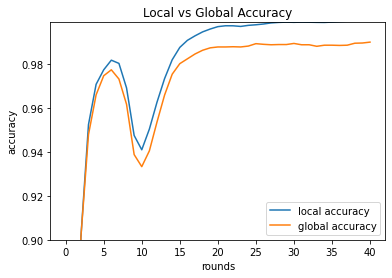

In [189]:
from matplotlib import pyplot as plt
dict1 = hist.metrics_distributed
dict2 = hist.metrics_centralized
plt.plot([i[0] for i in dict1['accuracy']], [i[1] for i in dict1['accuracy']], label='local accuracy')
plt.plot([i[0] for i in dict2['global_accuracy']], [i[1] for i in dict2['global_accuracy']], label='global accuracy')
plt.legend()
plt.xlabel('rounds')
plt.ylabel('accuracy')
plt.ylim(0.90, 0.999)
plt.title('Local vs Global Accuracy')
plt.show()


If simple dataset, use small alpha, otherwise use big alpha

In [190]:
import json
with open('hist_fedsoup_yugi_mnist_40.json', 'w') as f:
    json.dump(vars(hist), f)